# Użycie metody LDA do klasyfikacji artykułów z Wikipedii z kategorii 'Informatyka'

W poniższym skrypcie zostało pokazane przykładowe użycie metody LDA do klasyfikacji artykułów z Wikipedii . 

Artykuły na Wikipedii są pogrupowane w kategorie. Kategorie zaś tworzą drzewo gdzie jedna kategoria może być podkategorią innej. Na przykład Kategoria 'Informatyka' zawiera 56 artykułów ['Argumentowość', 'BRITE' ... ] ale również 22 podkategorie ['Algorytmika', 'Architektura komputerów' ... ]

W sumie całe poddrzewo kategorii 'Informatyka' zawiera 1240 kategorii dających w sumie 15210 artykułów

Pobrałem wszystkie artykuły z powyższych subkategorii i przetworzyłem za pomocą Web serwisu udostępnionego przez firmę Applica. Z przetworzonego teksu wybrałem słowa z tagiem (cTAG) - dokładnie takie same jak użyte w gramatyce TermoPL:
- 'ger' - odsłownik, 
- 'subst' - rzeczownik, 
- 'ppas' - imiesłów przymiotnikowy bierny, 
- 'adj' - przymiotnik,
- 'adja' - przymiotnik przyprzymiotnikowy 

Dla tak przygotowanych tekstów zbudowałem model LDA a następnie wybrałem najistotniejsze terminy i porównałem z zawartością listy terminów przygotowanej przy pomocy TermoPL.

In [99]:
from pandas import DataFrame, read_csv
import pandas as pd
import wikipedia
import re
import json
import random
import requests
import numpy
from gensim.models.phrases import Phraser
from gensim.models import Phrases
from sklearn.metrics import classification_report, confusion_matrix
from gensim import corpora, models
from bs4 import BeautifulSoup
import copy
from itertools import compress
import matplotlib.pyplot as plt

## Konfiguracja

In [2]:
wikipedia.set_lang("pl")
token = "53Fe6#fsLv6"

## Funkcja do sciągania i przetwarzania artykółow z wikipedii z danej kategorii

In [3]:
def get_wikipedia_texts_for_category(category):
    print("Category: ", category)
    categories_text = requests.get("https://pl.wikipedia.org/wiki/Kategoria:" + category).text
    soup = BeautifulSoup(categories_text, 'lxml')
    try:
        articles = re.findall(r'title=\"([a-zA-Z 0-9ąęłóńść_\- \(\)]*?)\"', str(soup.find_all(id="mw-pages")[0]))
    except:
        return dict()
    pages = dict()
    print("Downloading Wikipedia pages")
    processed = dict()
    for article in articles:
        try:
            page = wikipedia.page(article, auto_suggest=False, redirect=False)
            print('\t' + article)
            try:
                text = page.content
                text = text[0:text.find('== Zobacz też ==')] #without see also
                text = text[0:text.find('== Przypisy ==')] #without addons
                text = text[0:text.find('== Bibliografia ==')] #without bibliography
                url = 'https://nlp.applica.pl/ams-ws-nlp/rest/nlp/extended'
                payload = {"message":{"body":text},"token":token}
                headers = {'content-type': 'application/json'}
                response = requests.post(url, data=json.dumps(payload), headers=headers)
                processed[article] = json.loads(response.content)  
            except:
                print('\t**skipped**: ', article)
        except:
            print('\t' + article + " - topic ambiguous")
            continue
                
    return processed

## Pobieranie podkategorii z wybranej kategorii

In [4]:
def get_wikipedia_subcategories(category):
    categories_text = requests.get("https://pl.wikipedia.org/wiki/Kategoria:" + category).text
    soup = BeautifulSoup(categories_text, 'lxml')
    if len(soup.find_all(id="mw-subcategories")) == 0:
        return []
    subcategories = re.findall(r'>([a-zA-Z 0-9ąęłóńść_\- \(\)]*?)</a>', str(soup.find_all(id="mw-subcategories")[0]))
    return [w.replace(' ', '_') for w in subcategories]

In [8]:
newly_added = [[['Informatyka'], 0]]
cs_subcategories = []
while len(newly_added) > 0:
    curr_category_tuple = newly_added[0]
    if len(curr_category_tuple[0]) == 0:
        newly_added.remove(newly_added[0])
        continue
    curr_category = curr_category_tuple[0][0]
    curr_category_level = curr_category_tuple[1]
    print('   '*curr_category_level, curr_category)
    
    newly_added[0][0].remove(curr_category)
    
    subcategories = get_wikipedia_subcategories(curr_category)
    cs_subcategories.append(curr_category)
    newly_added = [[sorted(list(set(subcategories) - set(cs_subcategories))), curr_category_level+1]] + newly_added
    numpy.save('categories', cs_subcategories)

 Informatyka
    Algorytmika
       Algorytmy
          Algorytmy_ewolucyjne
          Algorytmy_graficzne
          Algorytmy_grafowe
          Algorytmy_kompresji
             Algorytmy_kompresji_stratnej
          Algorytmy_kryptograficzne
             Algorytmy_faktoryzacji
             Funkcje_skrótu
             Szyfry
                Szyfry_blokowe
                   Tryby_działania_szyfrów_blokowych
                Szyfry_klasyczne
                Szyfry_strumieniowe
             Testy_pierwszości
          Algorytmy_kwantowe
          Algorytmy_numeryczne
             Metody_iteracyjne
          Algorytmy_sortowania
          Algorytmy_tekstowe
          Algorytmy_w_robotyce
          Algorytmy_w_telekomunikacji
          Algorytmy_w_teorii_liczb
          Algorytmy_zamazywania_danych
       Automaty_komórkowe
       Generowanie_liczb_losowych
       Metody_optymalizacji
          Programowanie_liniowe
       Struktury_danych
          Drzewa_(informatyka)
    Architektura_kom

                Postacie_z_serii_Grand_Theft_Auto
                Postacie_z_serii_Metal_Gear
                Postacie_z_serii_gier_Gothic
                Postacie_z_serii_gier_Rayman
                Postacie_z_serii_gier_Tekken
                Postacie_ze_świata_Sonic_the_Hedgehog
          Filmy_o_tematyce_gier_komputerowych
          Filmy_oparte_na_grach_komputerowych
             Filmy_z_serii_Mortal_Kombat
             Filmy_z_serii_Resident_Evil
          Gatunki_gier_komputerowych
          Gry_komputerowe_w_produkcji
             Gry_komputerowe_w_fazie_wczesnego_dostępu
          Gry_komputerowe_według_firmy
             Gry_firmy_Valve
             Gry_firmy_Vicarious_Visions
             Gry_stworzone_przez_Team_Ico
             Gry_wydane_przez_Acclaim_Entertainment
             Gry_wydane_przez_Activision
             Gry_wydane_przez_Atari
             Gry_wydane_przez_CD_Projekt
             Gry_wydane_przez_Capcom
             Gry_wydane_przez_Deep_Silver
             

                   Gry_na_platformę_Game_Boy_Advance
                   Gry_na_platformę_PlayStation_2
                   Gry_na_platformę_Xbox
                Gry_na_konsolach_ósmej_generacji
                   Gry_na_platformę_Nvidia_Shield
                   Gry_na_platformę_Ouya
                   Gry_na_platformę_PlayStation_4
                      Gry_wykorzystujące_PlayStation_VR
                   Gry_na_platformę_Wii_U
                   Gry_na_platformę_Xbox_One
             Gry_na_komputerach_uniwersyteckich
             Gry_na_platformach_Apple
                Gry_na_platformę_Apple_IIGS
                Gry_na_platformę_Mac_OS
                Gry_na_platformę_iOS
                Gry_na_platformę_macOS
             Gry_na_platformach_Atari
                Gry_na_platformę_Atari_2600
                Gry_na_platformę_Atari_5200
                Gry_na_platformę_Atari_7800
                Gry_na_platformę_Atari_Falcon
                Gry_na_platformę_Atari_Jaguar
               

             Gry_z_serii_Star_Fox
             Gry_z_serii_Street_Fighter
             Gry_z_serii_TOCA
             Gry_z_serii_Tekken
             Gry_z_serii_The_Elder_Scrolls
             Gry_z_serii_The_Legend_of_Zelda
             Gry_z_serii_The_Settlers
             Gry_z_serii_The_Sims
             Gry_z_serii_Thief
             Gry_z_serii_Tomb_Raider
             Gry_z_serii_Total_War
             Gry_z_serii_Twierdza
             Gry_z_serii_Two_Worlds
             Gry_z_serii_Ultima
             Gry_z_serii_Uncharted
             Gry_z_serii_Unreal
             Gry_z_serii_WWE
             Gry_z_serii_Warcraft
             Gry_z_serii_Wizardry
             Gry_z_serii_Wolfenstein
             Gry_z_serii_Worms
             Gry_z_serii_Zoo_Tycoon
          Gry_komputerowe_według_stylu_graficznego
             Perspektywa_pierwszej_osoby
             Perspektywa_trzeciej_osoby
          Gry_komputerowe_według_świata_przedstawionego
             Gry_fantastycznonaukowe
      

                Windows_Vista
                Windows_XP
          Oprogramowanie_Sun_Microsystems
             OpenOffice
          Oprogramowanie_Sybase
          Oprogramowanie_firmy_Opera
       Programy_narzędziowe
          Emulatory_napędów
          Emulatory_terminali
          Oprogramowanie_diagnostyczne
          Oprogramowanie_testujące_wydajność
          Programy_do_kompresji
          Programy_do_nagrywania_dysków_optycznych
             Nero
       Programy_rozruchowe
       Rozszerzenia_oprogramowania
       Systemy_baz_danych
       Systemy_kopii_zapasowych_i_archiwizacji_danych
       Systemy_operacyjne
          AROS
          BSD
             FreeBSD
             OpenBSD
          BeOS
          Budowa_systemu_operacyjnego
             Biblioteki_programistyczne
                Biblioteki_graficzne
                   OpenGL
                   X_Window_System
                Frameworki
             Jądro_systemu_operacyjnego
             Pliki_wykonywalne
         

             Niemieccy_informatycy
             Norwescy_informatycy
             Polscy_informatycy
             Rosyjscy_informatycy
             Szwajcarscy_informatycy
             Szwedzcy_informatycy
             Włoscy_informatycy
          Laureaci_Nagrody_Turinga
          Laureaci_nagrody_Info_Star
          Programiści
          Twórcy_języków_programowania
       Maksymy_informatyczne
       Maskotki_informatyczne
       Nagrody_informatyczne
       Organizacje_informatyczne
          Fundacje_informatyczne
          Organizacje_geoinformatyczne
          Przedsiębiorstwa_informatyczne
             Amerykańskie_przedsiębiorstwa_informatyczne
             Australijskie_przedsiębiorstwa_informatyczne
             Brytyjskie_przedsiębiorstwa_informatyczne
             Chińskie_przedsiębiorstwa_informatyczne
             Francuskie_przedsiębiorstwa_informatyczne
             Izraelskie_przedsiębiorstwa_informatyczne
             Japońskie_przedsiębiorstwa_informatyczne
        

In [ ]:
numpy.save('wikipedia_articles/categories', cs_subcategories) 

In [4]:
cs_subcategories = numpy.load('categories.npy')

In [5]:
subcategories_texts = dict()
i = 0
for subcategory in cs_subcategories:
    i = i + 1
    print(i, '/', len(cs_subcategories))
    try:
        loaded_text = numpy.load('wikipedia_articles/' + subcategory + '.npy')
        print('loaded: ', subcategory)
        subcategories_texts[subcategory] = loaded_text.tolist()
    except:
        subcategories_texts[subcategory] = get_wikipedia_texts_for_category(subcategory)
        numpy.save('wikipedia_articles/' + subcategory, subcategories_texts[subcategory]) 

1 / 1254
loaded:  Informatyka
2 / 1254
loaded:  Algorytmika
3 / 1254
loaded:  Algorytmy
4 / 1254
loaded:  Algorytmy_ewolucyjne
5 / 1254
loaded:  Algorytmy_graficzne
6 / 1254
loaded:  Algorytmy_grafowe
7 / 1254
loaded:  Algorytmy_kompresji
8 / 1254
loaded:  Algorytmy_kompresji_stratnej
9 / 1254
loaded:  Algorytmy_kryptograficzne
10 / 1254
loaded:  Algorytmy_faktoryzacji
11 / 1254
loaded:  Funkcje_skrótu
12 / 1254
loaded:  Szyfry
13 / 1254
loaded:  Szyfry_blokowe
14 / 1254
loaded:  Tryby_działania_szyfrów_blokowych
15 / 1254
loaded:  Szyfry_klasyczne
16 / 1254
loaded:  Szyfry_strumieniowe
17 / 1254
loaded:  Testy_pierwszości
18 / 1254
loaded:  Algorytmy_kwantowe
19 / 1254
loaded:  Algorytmy_numeryczne
20 / 1254
loaded:  Metody_iteracyjne
21 / 1254
loaded:  Algorytmy_sortowania
22 / 1254
loaded:  Algorytmy_tekstowe
23 / 1254
loaded:  Algorytmy_w_robotyce
24 / 1254
loaded:  Algorytmy_w_telekomunikacji
25 / 1254
loaded:  Algorytmy_w_teorii_liczb
26 / 1254
loaded:  Algorytmy_zamazywania_dany

loaded:  Kodowania_znaków
222 / 1254
loaded:  ISO_8859
223 / 1254
loaded:  Strony_kodowe_DOS
224 / 1254
loaded:  Strony_kodowe_Windows
225 / 1254
loaded:  Unicode
226 / 1254
loaded:  Znaki_sterujące
227 / 1254
loaded:  Kodowanie_transportowe
228 / 1254
loaded:  Kody
229 / 1254
loaded:  Kody_i_oznaczenia_NATO
230 / 1254
loaded:  Kody_liniowe
231 / 1254
loaded:  Typy_danych
232 / 1254
loaded:  Znaki_niedrukowalne
233 / 1254
loaded:  Listy_związane_z_informatyką
234 / 1254
loaded:  Listy_oprogramowania
235 / 1254
loaded:  Porównania_oprogramowania
236 / 1254
loaded:  Listy_procesorów
237 / 1254
loaded:  Listy_związane_z_grami_komputerowymi
238 / 1254
loaded:  Listy_gier_komputerowych
239 / 1254
loaded:  Obliczenia_równoległe
240 / 1254
loaded:  Klastry
241 / 1254
loaded:  Oprogramowanie
242 / 1254
loaded:  Archiwizacja_plików
243 / 1254
loaded:  Programy_do_archiwizacji
244 / 1254
loaded:  Edytory_stron_WWW
245 / 1254
loaded:  Gry_komputerowe
246 / 1254
loaded:  Darmowe_gry_komputerowe
24

loaded:  Gry_komputerowe_wyprodukowane_w_Polsce
413 / 1254
loaded:  Gry_komputerowe_wyprodukowane_w_Rosji
414 / 1254
loaded:  Gry_komputerowe_wyprodukowane_w_Stanach_Zjednoczonych
415 / 1254
loaded:  Gry_komputerowe_wyprodukowane_w_Szwecji
416 / 1254
loaded:  Gry_komputerowe_wyprodukowane_w_Wielkiej_Brytanii
417 / 1254
loaded:  Gry_komputerowe_wyprodukowane_we_Francji
418 / 1254
loaded:  Gry_komputerowe_według_platformy
419 / 1254
loaded:  Granie_w_chmurze
420 / 1254
loaded:  Gry_na_platformę_Gaikai
421 / 1254
loaded:  Gry_na_platformę_OnLive
422 / 1254
loaded:  Gry_komputerowe_według_generacji
423 / 1254
loaded:  Gry_na_konsolach_czwartej_generacji
424 / 1254
loaded:  Gry_na_platformę_SNES
425 / 1254
loaded:  Gry_na_platformę_Sega_CD
426 / 1254
loaded:  Gry_na_platformę_TurboGrafx-16
427 / 1254
loaded:  Gry_na_konsolach_piątej_generacji
428 / 1254
loaded:  Gry_na_platformę_3DO
429 / 1254
loaded:  Gry_na_platformę_Game_Boy_Color
430 / 1254
loaded:  Gry_na_platformę_Nintendo_64
431 / 12

586 / 1254
loaded:  Gry_z_serii_Doom
587 / 1254
loaded:  Gry_z_serii_Dragon_Age
588 / 1254
loaded:  Gry_z_serii_Dragon_Ball
589 / 1254
loaded:  Gry_z_serii_Driver
590 / 1254
loaded:  Gry_z_serii_Duke_Nukem
591 / 1254
loaded:  Gry_z_serii_Dungeon_Siege
592 / 1254
loaded:  Gry_z_serii_Emergency
593 / 1254
loaded:  Gry_z_serii_Europa_Universalis
594 / 1254
loaded:  Gry_z_serii_FIFA
595 / 1254
loaded:  Gry_z_serii_FIFA_Manager
596 / 1254
loaded:  Gry_z_serii_Fable
597 / 1254
loaded:  Gry_z_serii_Fallout
598 / 1254
loaded:  Gry_z_serii_Far_Cry
599 / 1254
loaded:  Gry_z_serii_Final_Fantasy
600 / 1254
loaded:  Final_Fantasy_VII
601 / 1254
loaded:  Gry_z_serii_Forza_Motorsport
602 / 1254
loaded:  Gry_z_serii_Gears_of_War
603 / 1254
loaded:  Gry_z_serii_God_of_War
604 / 1254
loaded:  Gry_z_serii_Golden_Axe
605 / 1254
loaded:  Gry_z_serii_Gothic
606 / 1254
loaded:  Gry_z_serii_Gran_Turismo
607 / 1254
loaded:  Gry_z_serii_Grand_Theft_Auto
608 / 1254
loaded:  Gry_z_serii_Guild_Wars
609 / 1254
load

793 / 1254
loaded:  Przeglądarki_PDF
794 / 1254
loaded:  Programy_poczty_elektronicznej
795 / 1254
loaded:  Klienty_poczty_elektronicznej
796 / 1254
loaded:  Serwery_poczty_elektronicznej
797 / 1254
loaded:  Przeglądarki_internetowe
798 / 1254
loaded:  Internet_Explorer
799 / 1254
loaded:  Mozilla
800 / 1254
loaded:  Rozszerzenia_programu_Mozilla_Firefox
801 / 1254
loaded:  Silniki_przeglądarek_internetowych
802 / 1254
loaded:  Testy_Acid
803 / 1254
loaded:  Serwisy_internetowe_Google
804 / 1254
loaded:  YouTube
805 / 1254
loaded:  Filmy_z_YouTube
806 / 1254
loaded:  Kanały_YouTube
807 / 1254
loaded:  Kanały_YouTube_według_języka
808 / 1254
loaded:  Polskojęzyczne_kanały_YouTube
809 / 1254
loaded:  Osobowości_YouTube
810 / 1254
loaded:  Osobowości_YouTube_według_narodowości
811 / 1254
loaded:  Amerykańskie_osobowości_YouTube
812 / 1254
loaded:  Polskie_osobowości_YouTube
813 / 1254
loaded:  Skrypty_forów_dyskusyjnych
814 / 1254
loaded:  Systemy_zarządzania_treścią
815 / 1254
loaded:  W

loaded:  Amerykańskie_seriale_internetowe
1020 / 1254
loaded:  Polskie_seriale_internetowe
1021 / 1254
loaded:  Seriale_Netfliksa
1022 / 1254
loaded:  Telewizja_internetowa
1023 / 1254
loaded:  World_Wide_Web
1024 / 1254
loaded:  Elementy_stron_WWW
1025 / 1254
loaded:  Hipertekst
1026 / 1254
loaded:  Katalogi_internetowe
1027 / 1254
loaded:  Portale_internetowe
1028 / 1254
loaded:  Portale_informacyjne
1029 / 1254
loaded:  Strony_internetowe
1030 / 1254
loaded:  Komiksy_internetowe
1031 / 1254
loaded:  Strony_internetowe_według_tematu
1032 / 1254
loaded:  Internetowe_strony_pornograficzne
1033 / 1254
loaded:  Strony_internetowe_o_charakterze_religijnym
1034 / 1254
loaded:  Strony_internetowe_o_filmach
1035 / 1254
loaded:  Strony_internetowe_o_muzyce
1036 / 1254
loaded:  Strony_internetowe_o_sporcie
1037 / 1254
loaded:  Strony_szokujące
1038 / 1254
loaded:  W3C
1039 / 1254
loaded:  Webmastering
1040 / 1254
loaded:  Utwory_literackie_o_Internecie
1041 / 1254
loaded:  Media_strumieniowe
1

	Apple A5
	ARM9E
	AVIVO
	Azul Vega 2
	CCNUMA
	CPGA
	Crusoe
	Cyrix
	DEC Alpha
	Expeed
	F14 CADC
	FC-PGA
	FC-PGA2
	FLAGS
	Hitachi 6309
	Hudson Soft HuC6280
	I586
	I686
	IBM 801
	Integrated Facility for Linux
	Intel QuickPath Interconnect
	IP-Core
	Land Grid Array
	LEON
	Lista rozkazów procesora
	MCY7880
	Microblaze
	Mikroprocesor programowy
	MT6235
	Multiply-accumulate
	NEC V20
	NexGen
	Nintendo SA-1
	Nvidia Tegra
	Nvidia Tesla
	NX bit
	OPGA
	Pin grid array
	PowerQUICC
	PPGA
	Procesor audio
	Procesor grafenowy
	Procesor graficzny
	Procesor skalarny
	Procesor wektorowy
	Qualcomm Snapdragon
	Ricoh 2A03
	Ricoh 5A22
	Samsung Exynos
	Silicon on insulator
	SPARC64
	SpeedStep
	SPGA
	Procesor sygnałowy
	System mikroprocesorowy
	Texas Instruments OMAP
	Thermal Design Power
	Tryb chroniony
	Tryb rzeczywisty
	Tryb wirtualny
	U880D
	UltraSPARC T1
	Uniform Memory Access
	VIA C3
	VIA C7
	VIA Nano
	Wait state
	Watchdog
	WDC 65C02
	Wielowątkowość
	Wykonywanie poza kolejnością
	Zero wait state
1170 / 125

	Elektroniczny obieg dokumentów
	Elixir (system rozliczeń międzybankowych)
	Enterprise Service Bus
	EORI
	ERP5
	Euro Elixir
	Express Elixir
	GEAC System 21
	Global File System
	Grupa (informatyka)
	HADES
	HAFAS
	Harmonogram główny produkcji
	HeinOnline
	IMBIR
	Implex
	Integrator systemów
	Inteligentne systemy transportowe
	Internetowy System Aktów Prawnych
	ISACA
	ISZTAR
	IUCLID
	JEPI
	KOHA
	Krajowy Klaster Linuksowy
	Kurs 2008
	Legalis
	LIBRIS
	Magazyn wirtualny
	Magazynowy system informatyczny
	MAK (program)
	Manufacturing Execution System
	MICROS
	Microsoft Sure Step
	MikroHADES
	MSD-80
	Nowa Księga Wieczysta
	NUKAT
	Object Request Broker
	Ognivo
	Open Global File System
	Openbravo
	Otwarty System Archiwizacji
	PASAT
	Paybynet
	Planowanie zapotrzebowania materiałowego
	Planowanie zasobów wytwórczych
	Planowanie zdolności produkcyjnych
	POLTAX
	Projekt ISOK
	Prolib
	REACH IT
	Rechtsinformationssystem
	RSAnakonda
	SAK
	Samoorganizacja
	Sokrates Software
	Sowa (program)
	Spooling
	SYLO

C:\Users\Kamil\Anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\Kamil\Anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


	Lemat o pompowaniu - topic ambiguous
	Lemat o pompowaniu dla języków bezkontekstowych
	Lemat o pompowaniu dla języków regularnych
	Lemat Ogdena
	Metoda pierwszeństwa operatorów
	Natural Language Toolkit
	Notacja BNF
	Notacja EBNF
	Notacja postfiksowa
	Odwrotna notacja polska
	Płytki parsing
	Pochodna Brzozowskiego
	Podsłowo
	Postać normalna Greibach
	Postać normalna Kurody
	Predykat (języki formalne)
	Probabilistyczna gramatyka bezkontekstowa
	Słowo (matematyka)
	Symbol startowy
	System formalny
	System półthueowski
	System Thuego
	Zbiory First i Follow
1197 / 1254
Category:  Parsery
	Analizator składniowy
	Algorytm CYK
	Algorytm Earleya
	LALR
	Parser GLR
	Parser LL
	Parser LR
	Parser SLR
	Parser Ungera
1198 / 1254
Category:  Teoria_automatów
	Teoria automatów
	Asymmetric Numeral Systems
	Automat liniowo ograniczony
	Automat skończony
	Automat ze stosem
	Deterministyczny automat skończony
	Deterministyczny automat ze stosem
	Determinizacja automatu skończonego
	Diagram maszyny stanowe

1215 / 1254
Category:  Zecerzy
	Giambattista Bodoni
	Tadeusz Wacław Budynkiewicz
	Józef Daniluk
	Walenty Fiałek
	Edward Findley
	Horace Greeley
	Stefan Kalinowski
	Józef Antoni Kisiel
	Andrzej Kot
	**skipped**:  Andrzej Kot
	Stanisław Kuleszyński - topic ambiguous
	Nikodem Kunderewicz
	Ryszard Lebiest
	Otto Winzer
1216 / 1254
Category:  Drukowanie_przestrzenne
	Drukowanie przestrzenne
	Leki drukowane
	Osadzanie topionego materiału
	RepRap
	Selective laser sintering
	Stereolitografia
	STL (format pliku)
	Zortrax
1217 / 1254
Category:  Geoinformatyka
	Geoinformatyka
	Analiza przestrzenna
	Baza Danych Obiektów Topograficznych
	Bufor (geoinformatyka)
	Centralny Ośrodek Dokumentacji Geodezyjnej i Kartograficznej
	Cięcie poziomicowe
	Dane geograficzne
	Dane przestrzenne
	Datalogger GPS
	GDAL
	Geodeta (czasopismo)
	Geoinformacja
	Geoportal
	Geotagowanie
	Infrastruktura informacji przestrzennej
	LibLAS
	Mapa numeryczna
	Metadane infrastruktury informacji przestrzennej
	MicroStation
	Nakładanie

	G-Sync
	Gnuplot
	Graphical Kernel System
	IcoFX
	ImagiNAC
	Oekaki
	System okien
	Terragen
	UFRaw
	W Window System
	X Window System
	YafRay
1232 / 1254
Category:  Edytory_grafiki_rastrowej
	Edytor grafiki rastrowej
	Lista edytorów grafiki rastrowej
	Adobe After Effects
	Adobe Fireworks
	Adobe ImageReady
	Adobe Photoshop
	Adobe Photoshop Elements
	ArtRage
	Corel Painter
	Corel Photo-Paint
	DEGAS (oprogramowanie)
	Deluxe Paint
	GeoPaint
	GIMP
	GIMPShop
	Hugin (program)
	ImageMagick
	Imagine (wtyczka)
	IrfanView
	KolourPaint
	Krita
	MacPaint
	Microsoft Office Picture Manager
	Microsoft Paint
	Microsoft Photo Editor
	MyPaint
	Neopaint
	Paint Shop Pro
	Paintbrush
	PhotoFiltre
	Photoline
	Pixel (edytor graficzny)
	Pixelmator
	Texture Maker
	Tux Paint
	TVPaint
	Ulead PhotoImpact
	Xpaint
1233 / 1254
Category:  Edytory_grafiki_wektorowej
	Lista edytorów grafiki wektorowej
	Adobe After Effects
	Adobe Fireworks
	Adobe Flash
	Adobe Flash Lite
	Adobe FreeHand
	Adobe Illustrator
	AmiFIG
	Batik (prog

	Witosław Czerwonka
	Danuta Dąbrowska (artystka)
	Roman Dziadkiewicz
	Karolina Freino
	Peter Fuss
	Andy Goldsworthy
	Jerzy Grzegorski
	Rafał Jakubowicz
	Zuzanna Janin
	Jadwiga Janus
	Andrzej Karmasz
	Alicja Karska
	Adam Klimczak
	Leszek Knaflewski
	Robert Knuth
	Katarzyna Kozyra
	Marek Kubski
	Paweł Kula
	Maciej Kurak
	Zbigniew Libera (artysta)
	Piotr Macha
	Monika Mamzeta
	Chris Marker
	Antoni Mikołajczyk
	Jacek Niegoda
	Dariusz Nowak-Nova
	Adrian Paci
	Ewa Partum
	Anna Płotnicka
	Aleksandra Polisiewicz
	Leszek Przyjemski
	Józef Robakowski
	Zbigniew Rogalski
	Marek Rogulski
	Zbigniew Rybczyński
	Zygmunt Rytka
	Aleksandra Ska
	Piotr Skiba (artysta)
	Dominika Skutnik
	Piotr Szmitke
	Maciej Szupica
	Leon Tarasewicz
	Zbigniew Taszycki
	Ryszard Tokarczyk
	Anna Tyczyńska
	Jacek Tylicki
	Andrzej Wasilewski (artysta)
	Ryszard Waśko
	Aleksandra Went
	Waldemar Wojciechowski
	Zorka Wollny
	Igor Wójcik
	Karolina Wysocka
	Wojciech Zamiara
	Ewa Zarzycka
	Monika Zawadzki
	Marek Zygmunt
1250 / 1254
C

## Tworzenie słownika dzielącego artykuły na kategorie i subkategorie 

In [6]:
texts = []
for category in subcategories_texts:
    print("Category:", category)
    for article in subcategories_texts[category]:
        print("\t", article)
        article_texts = DataFrame(subcategories_texts[category][article])
        filtered_tokens = article_texts[article_texts['cTag'].isin(['ger', 'subst', 'ppas', 'adj', 'adja'])]
        for sentId in filtered_tokens['sentIdx'].unique():
            texts.append((category, article, sentId, filtered_tokens[filtered_tokens.sentIdx==sentId].base.values.tolist(), filtered_tokens[filtered_tokens.sentIdx==sentId].cTag.values.tolist()))

Category: Informatyka
	 Informatyka
	 Argumentowość
	 BRITE
	 Centrum danych
	 Czas dostępu
	 Czas rzeczywisty
	 Etykietowanie ról semantycznych
	 Extensible resource identifier
	 Heterogeniczność
	 Hook (informatyka)
	 Idempotentność
	 Technologia informacyjna
	 Informatyka afektywna
	 Informatyka przemysłowa
	 Informatyka społeczna
	 Informatyzacja
	 Kolejkowanie
	 Komputeryzacja
	 Kopiowanie (informatyka)
	 Krajowe Ramy Interoperacyjności
	 Libzip
	 Mapowanie
	 Media interaktywne
	 Moc obliczeniowa
	 Modulo
	 NASSCOM
	 Obrazy generowane komputerowo
	 Potrójna redundancja modularna
	 Proces drugoplanowy
	 Proces pierwszoplanowy
	 Projekt informatyczny
	 Quiesce
	 RINGrid
	 Skład informatycznych nośników danych
	 Stack trace
	 Stemming
	 Tagowanie
	 Teleinformatyka
	 Teoria systemów
	 Timeout (telekomunikacja)
	 Transfer umysłu
	 Twierdzenie Brenta
	 Universal Naming Convention
	 Usługi informatyczne
	 Wsparcie techniczne
	 Wymagania systemowe
	 Zadanie (informatyka)
	 Zawieszenie się

	 Sortowanie koktajlowe
	 Sortowanie przez kopcowanie
	 Sortowanie kubełkowe
	 Sortowanie przez łączenie naturalne
	 Sortowanie pozycyjne
	 Algorytm scalania
	 Sortowanie przez scalanie
	 Sortowanie Shella
	 Sieć sortująca
	 Sortowanie szybkie
	 Transformacja Schwartza
	 Sortowanie wielofazowe
	 Sortowanie przez wstawianie
	 Sortowanie przez wybieranie
	 Sortowanie zewnętrzne
	 Sortowanie przez zliczanie
Category: Algorytmy_tekstowe
	 Algorytm Aho-Corasick
	 Algorytm CYK
	 Dopasowanie do wzorca
	 Dopasowanie sekwencji
	 Drzewo sufiksowe
	 HITS
	 Algorytm Karpa-Rabina
	 Algorytm Knutha-Morrisa-Pratta
	 Odległość Damerau-Levenshteina
	 Odległość Hamminga
	 Odległość Levenshteina
	 PageRank
	 Podsłowo
	 TFIDF
Category: Algorytmy_w_robotyce
	 Algorytm całkowania wstecznego
	 Filtr Kalmana
	 Algorytm jakobianowy
	 Algorytm linearyzacji statycznej
	 Algorytm odsprzęgania wej-wyj
	 Planowanie akcji
	 Algorytmy sterowania
	 Algorytm sterowania sinusoidalnego
	 Algorytm Taylora
Category: Algory

	 Dekompilator
	 Metoda gumowej kaczuszki
	 Metryka oprogramowania
	 Optymalizacja oprogramowania
	 Punkt wstrzymania
	 Software Fault Tolerance
	 Spójność oprogramowania
	 Test pokrycia
	 Test pokrycia instrukcji programu
	 Test pokrycia rozgałęzień
	 Test pokrycia warunków logicznych
	 Test pokrycia wierszy programu
Category: Błędy_programów_komputerowych
	 Błąd (informatyka)
	 Bohr bug
	 Crash (informatyka)
	 Guru Meditation
	 Heartbleed
	 Heisenbug
	 Mariner 1
	 Naruszenie ochrony pamięci
	 Off by one
	 Ogólny błąd ochrony
	 Problem roku 2000
	 Problem roku 2038
	 Przekroczenie indeksu
	 Przekroczenie zakresu liczb całkowitych
	 Przepełnienie bufora
	 Przepełnienie sterty
	 Przepełnienie stosu
	 Regresja (informatyka)
	 Shellshock
	 Therac-25
	 Wyciek pamięci
Category: Bugtrackery
	 Bugtracker
	 Bugzilla
	 Flyspray
	 JIRA
	 Mantis Bug Tracker
	 OTRS
Category: Błędy_gier_komputerowych
	 Corrupted Blood Incident
	 Ekran śmierci
Category: Narzędzia_do_analizy_programów
	 Deasembler
	 

	 Pathping
	 Ping
	 Regedit
	 Rmdir
	 Rundll
	 Subst
	 Taskkill
	 Tasklist
	 Whoami
Category: Powłoki_systemowe
	 4DOS
	 Bash
	 Csh
	 Dash
	 Friendly interactive shell
	 Interpreter poleceń
	 JOM 1
	 Konqueror
	 Korn shell
	 Microsoft Bob
	 Nautilus (program)
	 Powłoka systemowa
	 REPL
	 Rsh (remote shell)
	 Tcsh
	 Thunar
	 Wiersz poleceń
	 Windows PowerShell
	 Zsh
Category: Funkcje_bezpieczeństwa
	 Funkcja bezpieczeństwa
	 Deduplikacja blokiem o stałej wielkości
	 Deduplikacja blokiem o zmiennej wartości
	 Deduplikacja progresywna
	 Dostępność (informatyka)
	 Eliminacja identycznych duplikatów
	 Niezaprzeczalność
	 Poufność
	 Rozliczalność
Category: Anonimowość
	 Anonimowość
	 Anonimowe P2P
	 Anonymizer
	 Bitmessage
	 Dowód z wiedzą zerową
	 Electronic Frontier Foundation
	 Ghostwriter
	 I2P
	 Incognito LiveCD
	 Off-the-record messaging
	 Share
	 Sieć miksująca
	 Silk Road
	 Tor (sieć anonimowa)
	 TorChat
	 Trasowanie cebulowe
	 Vidalia (program)
	 WikiLeaks
	 ZeroNet
Category: Autent

	 HDCP
	 HDDkey
	 Lacida
	 Maszyna Lorenza
	 Purple (maszyna szyfrująca)
	 SIGABA
	 Skytale
	 TgS-1 Dudek
	 Wytwórnia Radiotechniczna AVA
Category: Systemy_dostępu_warunkowego
	 System dostępu warunkowego
	 Conax
	 Cryptoworks
	 Irdeto
	 Mediaguard
	 PowerVu
Category: Usuwanie_danych
	 Bomba logiczna
	 Eraser
	 Formatowanie dysku
	 Kasowanie danych
	 Niszczarka
	 Usuwanie pliku
	 Zamazywanie pliku
Category: Rozliczalność
	 Rozliczalność
	 Audyt informatyczny
	 Cyfrowy rejestrator wideo
	 High Definition Composite Video Interface
	 Informatyka śledcza
	 Licznik odwiedzin strony WWW
	 Log (informatyka)
	 Log4j
	 Monitoring pracy komputera
	 Rejestracja czasu pracy
	 Rejestrator katastroficzny
	 Rejestrator rozmów
	 Rejestrator szybkiego dostępu
	 SIM (przedsiębiorstwo)
	 Simple Network Management Protocol
	 Syslog
	 Telewizja przemysłowa
Category: Systemy_kontroli_wersji
	 Bazaar
	 BitKeeper
	 Concurrent Versions System
	 CVSup
	 Darcs
	 Git (oprogramowanie)
	 GNU arch
	 IBM Rational Cle

	 Cyberprzemoc
	 Cyberstalking
	 Phishing
Category: Spam
	 Spam
	 Anulowanie wiadomości
	 Biała lista (informatyka)
	 Bluejacking
	 Czarna lista (informatyka)
	 DNSBL
	 DomainKeys
	 Greylisting
	 Harvester
	 Hashcash
	 Joe job
	 Link spam
	 Ochrona przed spamem
	 Okopipi
	 Open relay
	 PolSpam
	 Problem Scunthorpe
	 Scam
	 Sender Policy Framework
	 Serwer RBL
	 Spam blog
	 Spam w wyszukiwarkach
	 Spambot
	 SpamCop
	 Spamhaus
	 XRumer
Category: Standardy_bezpieczeństwa_teleinformatycznego
	 Common Criteria
	 Cryptographic Message Syntax
	 Federal Information Processing Standard
	 ITSEC
	 Konstrukcja zweryfikowana
	 Ochrona minimalna
	 Ochrona przez podział
	 Ochrona strukturalna
	 Ochrona uznaniowa
	 Ochrona z etykietowaniem
	 Ochrona z kontrolą dostępu
	 OpenSSH
	 Payment Card Industry Data Security Standard
	 TCSEC
	 TEMPEST
Category: Zarządzanie_prawami_cyfrowymi
	 Zarządzanie prawami cyfrowymi
	 Advanced Access Content System
	 Consumer Broadband and Digital Television Promotion Act

	 Joust
	 Karateka (gra komputerowa)
	 Knight Lore
	 Miecze Valdgira
	 Miecze Valdgira II
	 Moon Patrol
	 Pole Position (gra komputerowa)
	 River Raid
	 Robbo
	 Sea Wolf (automat do gry)
	 Space Invaders
	 Starquake
	 The Great American Cross-Country Road Race
	 Ultima I
	 Ultima II
	 Web Master
	 Zork
Category: Gry_na_platformy_BBC_Micro_i_Acorn_Electron
	 Elite
	 Tempest (gra komputerowa)
Category: Gry_na_platformę_Amiga
	 4D Sports Boxing
	 A-10 Tank Killer
	 A320 Airbus (gra komputerowa)
	 ABC Wide World of Sports Boxing
	 Abuse (gra komputerowa)
	 Action Fighter
	 Alfabet śmierci
	 Alien 3 (gra komputerowa)
	 Alien Breed
	 Alien Breed - Tower Assault
	 Alien Breed 3D
	 Alien Breed 3D II - The Killing Grounds
	 Alien Breed II - The Horror Continues
	 Ambermoon
	 Amberstar
	 Ancient Domains of Mystery
	 Another World (gra komputerowa)
	 Arabian Nights (gra komputerowa)
	 Archon (gra komputerowa)
	 Arkanoid
	 Armour-Geddon
	 Banshee (gra komputerowa)
	 Batman (gra komputerowa 1989)
	

	 Manic Miner
	 Nebulus
	 Operation Wolf
	 Peter Pack Rat
	 Pole Position (gra komputerowa)
	 Puszka Pandory (gra komputerowa)
	 Rebelstar
	 Renegade (gra komputerowa)
	 River Raid
	 Robin of the Wood
	 Sabre Wulf
	 Salamander
	 Shadow of the Beast
	 SimCity
	 Skool Daze
	 Spike in Transylvania
	 Starquake
	 Street Fighter
	 Tempest (gra komputerowa)
	 Turrican
	 World Games (gra komputerowa)
Category: Komputery_Atari
	 Rodzina 8-bitowych Atari
	 Atari PC
	 Atari Falcon
	 Atari Mega STE
	 Atari Portfolio
	 Atari ST
	 Atari STBook
	 Atari STacy
	 Atari STE
	 Atari Transputer Workstation
	 Atari TT
Category: Muzea_komputerów
	 Computer History Museum
	 DigiBarn Computer Museum
	 Muzeum Gry i Komputery Minionej Ery
	 Muzeum Historii Komputerów i Informatyki
	 Muzeum Konsol Gier Video w Karpaczu
	 National Museum of Computing
Category: Informatyka_kwantowa
	 Informatyka kwantowa
	 BB84
	 Bramka CNOT
	 Bramka fazy
	 Bramka Fredkina
	 Bramka Hadamarda
	 Bramka kwantowa
	 Bramka Toffoliego
	 

	 SMETANA
	 SMITH (język programowania)
	 Unlambda
	 Whirl
	 Whitespace
Category: Fortran
	 ALTRAN
	 Fortran
	 Fortran extended GRAph Algorithmic Language
	 GFortran
	 LAPACK
	 LINPACK
Category: Języki_bazodanowe
	 Clarion (język programowania)
	 OML
Category: Języki_xBase
	 Clipper
	 DBASE
	 DBF
	 Visual FoxPro
	 XBase
Category: Języki_zapytań
	 Język zapytań
	 Data Mining Extensions
	 Datalog
	 Informix-4GL
	 LINQ
	 Multidimensional Expressions
	 Object Definition Language
	 Object Query Language
	 ODQL
	 POSTQUEL
	 Query By Example
	 RDQL
	 SPARQL
	 XQuery
	 Zapytanie przestrzenne
Category: SQL
	 SQL
	 Commit
	 Create (SQL)
	 Drop (SQL)
	 Join (SQL)
	 MySQLi
	 Null (SQL)
	 Operator Union
	 SQL injection
	 Transact-SQL
	 Truncate
Category: PostgreSQL
	 PostgreSQL
	 EnterpriseDB
	 PgAdmin
	 PhpPgAdmin
	 PostGIS
	 POSTQUEL
	 Psql
Category: Języki_opisu_strony
	 Język opisu strony
	 ConTeXt
	 Encapsulated PostScript
	 HPGL
	 InterPress
	 LaTeX
	 Portable Document Format
	 PostScript
	 P

	 FreeCol
	 JDownloader
	 JEdit
	 LibreOffice
	 NetBeans
	 OpenProj
Category: Python
	 Python
	 Boa Constructor
	 CPython
	 Django (framework)
	 Eric
	 Global Interpreter Lock
	 IDLE
	 IronPython
	 Jinja2
	 Matplotlib
	 Natural Language Toolkit
	 PyCharm
	 Pygame
	 Pyglet
	 PyGTK
	 PyKDE
	 Pylons
	 PyPy
	 PyQt
	 PySonic
	 Python Imaging Library
	 RPython
	 Sphinx (generator dokumentacji)
	 Tkinter
	 Twisted
	 Wing IDE
	 WxPython
Category: Ruby
	 Ruby (język programowania)
	 IronRuby
	 JRuby
	 Mongrel
	 Phusion Passenger
	 Ramaze
	 Ruby on Rails
Category: Smalltalk
	 Smalltalk
	 Gemstone Smalltalk
	 Squeak
Category: UML
	 Unified Modeling Language
	 Agregacja (programowanie obiektowe)
	 Asocjacja (programowanie obiektowe)
	 PowerDesigner
	 Sparx Enterprise Architect
	 Aktor (UML)
	 UXF
Category: Diagramy_UML
	 Diagram czynności
	 Diagram interakcji
	 Diagram klas
	 Diagram komponentów
	 Diagram komunikacji
	 Diagram obiektów
	 Diagram stanów
Category: Programowanie_równoległe
	 Problem 

	 M4A
	 MDS (obraz)
	 Metalink
	 MHTML
	 MIDI
	 Mobipocket
	 MOD
	 Moving Picture Experts Group
	 MP1
	 MP2
	 MP3
	 Mp3PRO
	 MPEG-2
	 MPEG-3
	 MPEG-4
	 MPEG-4 część 2
	 MT9
	 Multipurpose Internet Mail Extensions
	 N-VOP
	 Nikon Electronic File
	 Notation Interchange File Format
	 Obraz (informatyka)
	 Odwołania znakowe SGML
	 Open Document Architecture
	 Open eBook
	 Open Packaging Conventions
	 OpenDocument
	 Plik binarny
	 Plik płaski
	 Plikopartycja
	 PLS (format pliku)
	 Portable Document Format
	 PVM (format pliku)
	 QCIF
	 Qpel
	 RAW
	 Replica
	 Resource Description Framework
	 Rich Text Format
	 S3M (format pliku)
	 Simple File Verification
	 Simple Outline XML
	 SMDL
	 SMILES
	 Specyfikacja techniczna OpenDocument
	 SQCIF
	 SRT
	 SXW
	 Text Encoding Initiative
	 TRC (Formaty plików komputerowych)
	 True Audio
	 Typ MIME
	 Uuencode
	 VCalendar
	 VCard
	 WavPack
	 Web Open Font Format
	 Windows Media Audio
	 Windows Metafile
	 WinHelp
	 Xilinx Netlist Format
	 XLS
	 XM (format p

	 Problem ABA
	 Bariera pamięci
	 Beowulf (informatyka)
	 Compare-and-swap
	 Expeed
	 Fetch-and-add
	 Intel Threading Building Blocks
	 Miara Karpa-Flatta
	 Non-Uniform Memory Access
	 Parallel Thread Execution
	 Prawo Amdahla
	 Prawo Gustafsona
	 Przyspieszenie (obliczenia równoległe)
	 Tablica systoliczna
	 Transactional Synchronization Extensions
Category: Klastry
	 Klaster komputerowy
	 Bem (superkomputer)
	 Beowulf (informatyka)
	 Distributed Hardware Evolution Project
	 Enabling Grids for E-SciencE
	 Galera (superkomputer)
	 Globus Toolkit
	 Green500
	 Grid (system)
	 Krajowy Klaster Linuksowy
	 MOSIX
	 Nautilus (superkomputer)
	 Nova (superkomputer)
	 OpenMosix
	 Polska Infrastruktura Gridowa PL-Grid
	 Prometheus (superkomputer)
	 Single System Image
	 TOP500
	 Tryton (superkomputer)
	 Zeus (superkomputer)
Category: Oprogramowanie
	 Oprogramowanie
	 Program komputerowy
	 R-Studio
	 Aktualizacja wsteczna
	 Aktywacja systemu
	 Aplikacja mobilna
	 Aplikacja przenośna
	 Aplikacja sp

	 Komputerowa gra labiryntowa
	 Komputerowa gra logiczna
	 Komputerowa gra muzyczna
	 Komputerowa gra platformowa
	 Komputerowa gra przygodowa
	 Komputerowa gra sportowa
	 Komputerowa gra strategiczna
	 Komputerowa gra survivalowa
	 Komputerowa gra symulacyjna
	 Komputerowa gra zręcznościowa
	 Komputerowe wyścigi
	 Massively multiplayer online game
	 Massively multiplayer online strategic game
	 MMORPG
	 Multiplayer online battle arena
	 Non-game
	 Powieść wizualna
	 Przygodowa gra akcji
	 Roguelike
	 Skradanka
	 Strategiczna gra czasu rzeczywistego
	 Strategiczna gra turowa
	 Strzelanka
	 Strzelanka pierwszoosobowa
	 Strzelanka trzecioosobowa
	 SUD
	 Survival horror
	 Symulator lotu
	 Symulator socjalny
	 Taktyczna gra fabularna
	 Tower defense
Category: Gry_komputerowe_w_produkcji
Category: Gry_komputerowe_w_fazie_wczesnego_dostępu
	 7 Days to Die
	 DayZ (gra komputerowa)
	 H1Z1
	 Paladins
	 Rust (gra komputerowa)
	 Star Citizen
Category: Gry_komputerowe_według_firmy
Category: Gry_fi

Category: Gry_wydane_przez_The_3DO_Company
	 Crusaders of Might and Magic
	 Heroes of Might and Magic III
	 Heroes of Might and Magic IV
	 Legends of Might and Magic
	 Might and Magic IX
	 Warriors of Might and Magic
Category: Gry_wydane_przez_Ubisoft_Entertainment
	 Anno 2205
	 Capitalism II
	 Cold Fear
	 Driver 76
	 Far Cry
	 Far Cry 2
	 Far Cry 3
	 Far Cry 4
	 Far Cry Instincts
	 For Honor
	 From Dust
	 I Am Alive
	 Prince of Persia (gra komputerowa 2008)
	 Quantum of Solace (gra komputerowa)
	 Rabbids Go Home
	 Rayman (gra komputerowa)
	 Rayman Legends
	 Rayman M
	 Rayman Origins
	 Rayman Raving Rabbids TV Party
	 Red Steel
	 Seven Kingdoms II
	 Sniper Elite
	 Szalone przygody Kaczora Donalda
	 Theocracy (gra komputerowa)
	 Warlords Battlecry II
	 Watch Dogs
	 XIII (gra komputerowa)
Category: Gry_wyprodukowane_przez_BioWare
	 Jade Empire
	 Mass Effect
	 Mass Effect 2
	 Mass Effect 3
	 Neverwinter Nights
	 Wrota Baldura (gra komputerowa)
Category: Gry_wyprodukowane_przez_Black_Isle_

	 Para Para Paradise
	 Peter Pack Rat
	 Pole Position (gra komputerowa)
	 Pong
	 Pump It Up
	 Renegade (gra komputerowa)
	 Ridge Racer V
	 River Raid
	 Salamander
	 Samurai Shodown
	 Samurai Shodown II
	 Samurai Shodown III
	 Samurai Shodown IV
	 Sea Wolf (automat do gry)
	 Shark Jaws
	 Soulcalibur III
	 Space Invaders
	 Space Panic
	 Street Fighter
	 Super Contra
	 Tank Battalion
	 Tekken (gra komputerowa)
	 Tekken 2
	 Tekken 3
	 Tekken Tag Tournament
	 Tekken Tag Tournament 2
	 Tempest (gra komputerowa)
	 The House of the Dead
	 The House of the Dead 2
	 The Punisher (gra arcade)
	 The Typing of the Dead
	 Truxton (gra komputerowa)
	 Ultimate Mortal Kombat 3
	 Virtua Cop
	 Waku Waku 7
	 Złota era gier arcade
Category: Gry_epizodyczne
	 Gra epizodyczna
	 Dreamfall Chapters
	 Higurashi no naku koro ni
	 Life Is Strange
	 The Orange Box
	 Tales from the Borderlands
	 The Walking Dead (gra komputerowa)
	 The Wolf Among Us
Category: Gry_grozy
	 Blood (gra komputerowa)
	 Darkeden
	 Dead Sp

	 Grand Theft Auto IV
	 Heavenly Sword
	 Heretic II
	 Hydrophobia
	 Ico
	 Indiana Jones and the Infernal Machine
	 Indiana Jones and the Staff of Kings
	 Infamous
	 Infernal (gra komputerowa)
	 Just Cause 3
	 Knight Lore
	 The Legend of Zelda
	 Lego Island
	 Lego Piraci z Karaibów
	 Little Big Adventure
	 Little Big Adventure 2
	 Mad Max (gra komputerowa 2015)
	 Madagaskar (gra komputerowa)
	 MediEvil 2
	 Modi i Nanna
	 Of Orcs and Men
	 Ojciec chrzestny (gra komputerowa)
	 Overgrowth
	 Overlord (gra komputerowa)
	 Pathologic
	 Prince of Persia (gra komputerowa 2008)
	 Quantum Break
	 Rise of the Tomb Raider
	 Sabre Wulf
	 Saints Row 2
	 Saints Row IV
	 Second Sight (gra komputerowa)
	 Shadow of the Colossus
	 Shadow the Hedgehog (gra komputerowa)
	 The Simpsons Game
	 Stranded 2
	 The Last of Us
	 The Last of Us Part II
	 The Saboteur
	 The Typing of the Dead
	 This War of Mine
	 Tomb Raider (gra komputerowa 2013)
	 Trespasser
	 Watch Dogs
	 Watch Dogs 2
	 X-Blades
	 Yakuza (gra kompu

	 RTL Ski Jumping 2007
	 RTL Skispringen 2000
	 Sensible Soccer (seria)
	 Ski Jump Challenge 2003
	 Ski Jump Challenge 2004
	 Ski Jump International
	 Skoki narciarskie 2004
	 Skoki narciarskie 2005
	 Skoki narciarskie 2006
	 Soccer Manager
	 Speedball (gra komputerowa)
	 Speedball (seria)
	 Sports Champions
	 Steep (gra)
	 TEAM
	 Tennis for Two
	 Total Club Manager 2005
	 Trophy Manager
	 UEFA Euro 2000
	 UEFA Euro 2004
	 UEFA Euro 2008 (gra komputerowa)
	 UEFA Euro 2012 (gra komputerowa)
	 Urban Trial Freestyle
	 Virtua Tennis (seria)
	 Virtua Tennis 3
	 Virtua Tennis 4
	 Virtua Tennis 2009
	 Wii Sports
	 Wii Sports Resort
	 World Games (gra komputerowa)
	 WWE Smackdown vs Raw 2009
Category: Komputerowe_gry_sportowe_z_trybem_kariery
	 F1 2009
	 F1 2010
	 FIFA 08
	 FIFA 09
	 FIFA 10
	 FIFA 11
	 FIFA 12
	 FIFA 13
	 FIFA 14
	 FIFA 15
	 FIFA 17
	 FIFA 18
	 Fight Night Champion
	 Fight Night Round 4
	 Grid (gra komputerowa)
	 Grid 2
	 NBA 2K11
	 Pro Cycling Manager
	 Pro Evolution Soccer 

	 Rise of Prussia
	 Stellaris
	 Tropico 3
	 Tropico 4
	 Victoria II
Category: Komputerowe_gry_wieloosobowe
	 Gra wieloosobowa
	 Grand Theft Auto Online
	 Hedgewars
	 Shadow the Hedgehog (gra komputerowa)
	 Sonic Advance
	 Sonic Adventure 2
	 Sonic Heroes
	 Sonic Riders
	 Sonic the Hedgehog (gra komputerowa 2006)
	 War Thunder
	 Warmux
	 World of Tanks
	 World of Warplanes
	 World of Warships
	 Worms (gra komputerowa)
	 Worms 3D
	 Worms Armageddon
	 Worms Blast
	 Worms Reinforcements
	 Worms World Party
Category: Komputerowe_gry_zręcznościowe
	 1942 (gra komputerowa)
	 Arabian Nights (gra komputerowa)
	 Archon (gra komputerowa)
	 Arkanoid
	 Asteroids
	 Atak na Pearl Harbor (gra komputerowa)
	 Audiosurf
	 Bomberman
	 Boulder Dash
	 Dig Dug
	 Diggers
	 Elasto Mania
	 Elite
	 Evolva
	 Final Fantasy VII Snowboarding
	 Formula One Arcade
	 Fruit Ninja
	 Fruity Frank
	 Galaga
	 Galaxian
	 Hans Kloss (gra komputerowa)
	 Harry Potter i Czara Ognia (gra komputerowa)
	 Harry Potter i Kamień Filoz

	 The Operational Art of War
	 Warlords
	 Worms (gra komputerowa 2007)
	 Worms (gra komputerowa)
	 Worms 2
	 Worms 3D
	 Worms Armageddon
	 Worms Reinforcements
	 Worms Revolution
	 Worms Ultimate Mayhem
	 Worms World Party
Category: Strzelanki
	 Abuse (gra komputerowa)
	 Batsugun
	 BZFlag
	 Chaos Engine
	 Chicken Invaders
	 Child of Eden
	 Commando (gra komputerowa)
	 Contra
	 Electro Body
	 Gun Fight
	 Hatred
	 Heli Heroes
	 Insurgency
	 Sniper Elite
	 Soldat
	 Space Invaders
	 Super Contra
	 Tempest (gra komputerowa)
	 Terrorist Takedown 2
	 The Binding of Isaac
	 Touhou Project
	 Truxton (gra komputerowa)
	 Vortex (gra komputerowa)
	 Warblade
Category: Rail_shootery
	 The Adventures of Bayou Billy
	 Die Hard Trilogy
	 Lylat Wars
	 Panzer Dragoon
	 Panzer Dragoon Orta
	 Rez
	 Starwing
	 The House of the Dead
	 Virtua Cop
Category: Strzelanki_pierwszoosobowe
	 Strzelanka pierwszoosobowa
	 Alien Rage
	 Alpha Prime
	 Arma 2
	 Arma 3
	 AssaultCube
	 The Ball
	 Battlefield 1
	 Battlefield

	 Ridge Racer (gra komputerowa 1993)
	 Ridge Racer (gra komputerowa 2004)
	 Ridge Racer (gra komputerowa 2011)
	 Ridge Racer 2
	 Ridge Racer 3DS
	 Ridge Racer 6
	 Ridge Racer 7
	 Ridge Racer 64
	 Ridge Racer Revolution
	 Ridge Racer V
	 Romancing Saga
	 Salamander
	 Samurai Shodown
	 School Days (powieść wizualna)
	 Shadow of Rome
	 Shadow of the Colossus
	 Shenmue
	 Shining Force
Category: Gry_komputerowe_wyprodukowane_w_Kanadzie
	 Ace of Aces
	 BioShock
	 Company of Heroes 2
	 Dragon Age II
	 Duke Nukem Forever
	 Far Cry 2
	 Far Cry 3
	 Far Cry 4
	 Far Cry Instincts
	 Far Cry Primal
	 Fez (gra komputerowa)
	 FIFA 15
	 FIFA 16
	 FIFA 17
	 FIFA 18
	 For Honor
	 Grand Prix Circuit
	 Homefront
	 Homeworld
	 Homeworld 2
	 Jade Empire
	 Jazzpunk
	 Mass Effect
	 Mass Effect 2
	 Mass Effect 3
	 Mass Effect Galaxy
	 Neverwinter Nights
	 Outlast (gra komputerowa)
	 Outlast 2
	 Prince of Persia (gra komputerowa 2008)
	 Prototype (gra komputerowa)
	 Prototype 2
	 Quantum of Solace (gra komputero

	 OXO
	 Populous
	 Power F1
	 Project Gotham Racing
	 Project Gotham Racing 2
	 Project Gotham Racing 3
	 Project Gotham Racing 4
	 Proteus (gra komputerowa)
	 Pure (gra komputerowa)
	 Quantum of Solace (gra komputerowa)
	 Robin of the Wood
	 Rust (gra komputerowa)
	 Shadow of the Beast
	 Shift 2 Unleashed
	 Sleeping Dogs
	 Spike in Transylvania
	 Spintires
	 Stuntman
	 SuperCar Challenge
	 Tearaway
	 Test Drive 4
	 Test Drive Overdrive
	 The Cat Lady
	 The Crew
	 The Italian Job (gra komputerowa)
	 TOCA 2 Touring Cars
	 TOCA Race Driver (gra komputerowa)
	 TOCA Race Driver 2
	 TOCA Race Driver 3
	 TOCA Touring Car Championship
	 TOCA World Touring Cars
	 Twierdza 3
	 Vanishing Point (gra komputerowa)
	 Virtua Tennis 4
	 Vortex (gra komputerowa)
	 Warzone 2100
	 Worms (gra komputerowa)
	 Worms Armageddon
	 Xenonauts
Category: Gry_komputerowe_wyprodukowane_we_Francji
	 Alone in the Dark (gra komputerowa)
	 Another World (gra komputerowa)
	 Arx Fatalis
	 Asphalt 3D
	 Asphalt Urban GT 2
	

	 Myst
	 Panzer Dragoon
	 Phantasmagoria
	 Quake
	 Rayman (gra komputerowa)
	 Riven
	 Samurai Shodown III
	 Samurai Shodown IV
	 Snatcher
	 Sonic R
	 The House of the Dead
	 Tomb Raider (gra komputerowa 1996)
	 Ultimate Mortal Kombat 3
	 Virtua Cop
	 Virus Buster Serge
	 Waku Waku 7
Category: Gry_na_konsolach_siódmej_generacji
Category: Gry_na_platformę_Gizmondo
	 Richard Burns Rally
Category: Gry_na_platformę_Nintendo_DS
	 Asphalt Urban GT 2
	 Band Hero
	 Brothers in Arms DS
	 Cartoon Network Racing
	 Civilization Revolution
	 Crash of the Titans
	 Crash Tag Team Racing
	 Czarodzieje z Waverly Place (gra komputerowa)
	 Eragon (gra komputerowa)
	 Ferrari Challenge Trofeo Pirelli
	 FIFA 07
	 FIFA 08
	 FIFA 09
	 FIFA 10
	 FIFA 11
	 FIFA 12
	 FIFA Street 2
	 FIFA World Cup 2006
	 Final Fantasy III
	 Final Fantasy IV
	 Harry Potter i Czara Ognia (gra komputerowa)
	 Harry Potter i Zakon Feniksa (gra komputerowa)
	 Higurashi no naku koro ni
	 Indiana Jones and the Staff of Kings
	 Lode Runne

	 Fahrenheit (gra komputerowa)
	 Fallout 3
	 Far Cry
	 Far Cry (seria)
	 Far Cry 2
	 Far Cry 3
	 Far Cry 4
	 Fez (gra komputerowa)
	 FIFA 07
	 FIFA 08
	 FIFA 09
	 FIFA 10
	 FIFA 11
	 FIFA 12
	 FIFA 13
	 FIFA 14
	 FIFA 15
	 FIFA 16
	 FIFA 17
	 FIFA 18
	 FIFA World Cup 2006
	 Fight Night Champion
	 Fight Night Round 4
	 Final Fantasy XI
	 Final Fantasy XIII
	 Final Fantasy XIII-2
	 Forza Horizon
	 Forza Motorsport 2
	 Forza Motorsport 3
	 From Dust
	 Galaga
	 Gears of War
	 Gears of War 2
	 Gears of War 3
	 Golden Axe
	 Grand Theft Auto IV
	 Grand Theft Auto Online
	 Grand Theft Auto V
	 Gray Matter
	 Grid (gra komputerowa)
	 Grid 2
	 Guardians of Middle-earth
	 Guitar Hero 5
	 Guitar Hero II
Category: Gry_z_obsługą_Kinecta
	 Child of Eden
	 Dance Central
	 Dance Central 2
	 FIFA 13
	 FIFA 14
	 FIFA 15
	 Forza Horizon
	 Forza Motorsport 4
	 Just Dance 2014
	 Kinect Joy Ride
	 Kinect Sports
	 Kinectimals
	 Mass Effect 3
	 Minecraft
	 Virtua Tennis 4
Category: Gry_na_konsolach_szóstej_gene

	 Richard Burns Rally
	 RollerCoaster Tycoon
	 Second Sight (gra komputerowa)
	 Serious Sam (gra komputerowa)
	 Serious Sam 2
	 Shadow the Hedgehog (gra komputerowa)
	 Silent Hill 2
	 The Sims 2
	 Sonic Heroes
	 Sonic Riders
	 SpyHunter
	 Still Life (gra komputerowa)
	 Sudeki
	 Syberia (gra komputerowa)
	 Syberia (seria)
	 Syberia II
Category: Gry_na_konsolach_ósmej_generacji
Category: Gry_na_platformę_Nvidia_Shield
	 Half-Life 2
	 Portal (gra komputerowa)
Category: Gry_na_platformę_Ouya
	 The Ball
	 Final Fantasy III
	 The Walking Dead (gra komputerowa)
Category: Gry_na_platformę_PlayStation_4
	 7 Days to Die
	 Among the Sleep
	 Another World (gra komputerowa)
	 Armikrog
	 Arslan senki
	 Battlefield 1
	 Battlefield 4
	 Battlefield Hardline
	 BioShock
	 BioShock 2
	 BioShock Infinite
	 Bloodborne
	 Borderlands 2
	 Dark Souls III
	 DayZ (gra komputerowa)
	 DC Universe Online
	 Dead Nation
	 Destiny (gra komputerowa)
	 Diablo III
	 Dishonored 2
	 Doom (gra komputerowa 2016)
	 Dreamfall C

	 Anomaly Warzone Earth
	 AssaultCube
	 Bastion (gra komputerowa)
	 Battle for Wesnoth
	 BioShock 2
	 Borderlands
	 Borderlands 2
	 Botanicula
	 Braid
	 BZFlag
	 Call of Duty
	 Call of Duty 2
	 Cave Story
	 Championship Manager 4
	 Chess (informatyka)
	 Cities in Motion
	 City of Heroes
	 Civilization IV
	 Civilization V
	 Counter-Strike
	 Darwinia
	 Dear Esther
	 Dofus
	 Dota 2
	 Dreamfall Chapters
	 EA Land
	 Eufloria
	 Eve Online
	 Fable (gra komputerowa)
	 Fahrenheit (gra komputerowa)
	 Fallen Earth
	 Fez (gra komputerowa)
	 Firewatch
	 FlatOut 2
	 FlightGear
	 FreeCol
	 Grand Theft Auto III
	 Half-Life
	 Half-Life 2
	 Harry Potter i Komnata Tajemnic (gra komputerowa)
	 Harry Potter i Zakon Feniksa (gra komputerowa)
	 Hearthstone
	 Hearts of Iron (seria)
	 Hearts of Iron IV
	 Her Story
	 Heroes of Might and Magic V
	 Homeworld
	 Homeworld 2
	 Humble Bundle
	 Infinite Crisis (gra komputerowa)
	 Jazzpunk
	 Kerbal Space Program
	 League of Legends
	 Legend of Grimrock
	 Lone Survivor


	 Alan Wake
	 Alicja w Krainie Serc
	 Alien Crossfire
	 Alien Nations 2
	 Alien Rage
	 Alien Swarm
	 Allods Online
	 Alone in the Dark (gra komputerowa 2008)
	 Alpha Centauri (gra komputerowa)
	 Alpha Prime
	 Altitude (gra komputerowa)
	 American Conquest
	 American Truck Simulator
	 Amerzone
	 Among the Sleep
	 Anachronox
	 Anarchy Online
	 Ancient Domains of Mystery
	 Angband (gra komputerowa)
	 Anno 1404
	 Anno 1503
	 Anno 1602
	 Anno 1701
	 Anno 2070
	 Anno 2205
	 Anomaly Warzone Earth
	 Another War
	 Another World (gra komputerowa)
	 Antichamber
	 Arcania
	 Archangel (gra komputerowa)
	 Arma 2
	 Arma 3
	 Armikrog
	 Art of Murder (seria)
	 Arx Fatalis
	 AssaultCube
	 Asteroids
	 Atak na Pearl Harbor (gra komputerowa)
	 Atlantis Evolution
	 Atlantis II
	 Audiosurf
	 The Ball
	 Ballance
	 Bastion (gra komputerowa)
	 Battle Arena Toshinden 2
	 Battle for Wesnoth
	 Battle Realms
	 Battlefield 1
	 Battlefield 2
	 Battlefield 3
	 Battlefield 4
	 Battlefield 1942
	 Battlefield 2142
	 Batt

	 Temple Run
	 The Oregon Trail
	 The Walking Dead (gra komputerowa)
	 This War of Mine
	 World of Goo
	 Worms (gra komputerowa 2007)
	 X-Plane (symulator)
Category: Gry_na_platformę_CD-i
	 Defender of the Crown
	 Myst
Category: Gry_na_platformę_N-Gage
	 Asphalt Urban GT 2
	 Crash Nitro Kart
	 FIFA 08
Category: Gry_na_platformę_Neo_Geo
	 Art of Fighting
	 Fatal Fury
	 Metal Slug
	 Metal Slug 2
	 Samurai Shodown
	 Samurai Shodown II
	 Samurai Shodown III
	 Samurai Shodown IV
	 Waku Waku 7
Category: Gry_na_platformę_PC
Category: Gry_na_platformę_FreeBSD
	 AssaultCube
	 Freeciv
	 Warmux
Category: Gry_na_platformę_Linux
	 7 Days to Die
	 Abuse (gra komputerowa)
	 Alien Crossfire
	 Alpha Centauri (gra komputerowa)
	 Among the Sleep
	 Ancient Domains of Mystery
	 Angband (gra komputerowa)
	 Anomaly Warzone Earth
	 Armikrog
	 AssaultCube
	 Bastion (gra komputerowa)
	 Battle for Wesnoth
	 Botanicula
	 Braid
	 Bridge Builder
	 BZFlag
	 Cave Story
	 Civilization V
	 Civilization VI
	 Counter-Str

	 Silent Hill 3
	 Silent Storm
	 SimCity 4
	 Ski Jump Challenge 2003
	 Skoki narciarskie 2004
	 Soldiers of Anarchy
	 Sonic Battle
	 Sonic Heroes
	 SpellForce
	 SpyHunter
	 Stuntman
	 The Black Mirror
	 The House of the Dead 2
	 TOCA Race Driver (gra komputerowa)
	 TOCA World Touring Cars
	 TrackMania
	 Unreal Tournament 2003
	 Vietcong (gra komputerowa)
	 Warblade
	 Worms 3D
	 XIII (gra komputerowa)
Category: 2003_w_sportach_elektronicznych
	 Electronic Sports World Cup 2003
	 World Cyber Games 2003
Category: 2004_w_grach_komputerowych
	 2004 w grach komputerowych
	 Ape Academy
	 Atlantis Evolution
	 Ballance
	 Battlefield Vietnam
	 Beyond Divinity
	 BloodRayne 2
	 Breed
	 Cave Story
	 Chariots of War
	 City of Heroes
	 Clannad (gra komputerowa)
	 Colin McRae Rally 04
	 Crash Bandicoot Purple
	 Crash Twinsanity
	 D-Day (gra komputerowa)
	 Donkey Kong Jungle Beat
	 Donkey Konga
	 Doom 3
	 Driver (gra komputerowa)
	 Driver 2
	 EverQuest II
	 Evil Genius
	 Far Cry
	 FIFA Football 2005
	 

	 Alone in the Dark (gra komputerowa 2008)
	 AssaultCube
	 Audiosurf
	 Braid
	 Burnout Dominator
	 Civilization Revolution
	 Combat Arms
	 Crash Time II
	 Crimson Gem Saga
	 Crysis Warhead
	 Darkeden
	 Dead Space
	 Death Note
	 Devil May Cry 4
	 Donkey Kong Jungle Beat
	 Driver (gra komputerowa)
	 Euro Truck Simulator
	 Fable II
	 Fallout 3
	 Far Cry 2
	 Ferrari Challenge Trofeo Pirelli
	 FIFA 09
	 FIFA Manager 09
	 FIM Speedway Grand Prix 3
	 Gears of War 2
	 Grand Theft Auto IV
	 Grid (gra komputerowa)
	 GTR Evolution
	 Hearts of Iron II
	 Hotel Giant 2
	 JamLegend
	 Left 4 Dead
	 LocoRoco 2
	 Mario Kart Wii
	 Mario Party 8
	 Mega Man 9
	 Men of War
	 MySims Kingdom
	 NHL 09
	 Penumbra (seria)
	 Pikmin
	 Pilot Academy
	 Pirates of the Burning Sea
	 Prince of Persia (gra komputerowa 2008)
	 Pro Evolution Soccer 2009
	 Project Gotham Racing 4
	 Pure (gra komputerowa)
	 Quantum of Solace (gra komputerowa)
	 Rayman Raving Rabbids TV Party
	 Resistance 2
	 Rock Band 2
	 Saints Row
	 Saint

	 Grid 2
	 Ingress (gra)
	 Kantai Collection
	 Killzone Najemnik
	 Neverwinter (gra komputerowa)
	 Outlast (gra komputerowa)
	 Path of Exile
	 Payday 2
	 Proteus (gra komputerowa)
	 Rayman Legends
	 Saints Row IV
	 Shadowgun
	 Shelter (gra komputerowa)
	 SimCity (gra komputerowa 2013)
	 Super Mario 3D World
	 Surgeon Simulator 2013
	 Tearaway
	 The Last of Us
	 The Showdown Effect
	 The Stanley Parable
	 The Wolf Among Us
	 Tomb Raider (gra komputerowa 2013)
	 Urban Trial Freestyle
	 World of Warplanes
	 Zeno Clash II
Category: 2014_w_grach_komputerowych
	 2014 w grach komputerowych
	 2014 FIFA World Cup Brazil
	 2048 (gra komputerowa)
	 Age of Mythology
	 Among the Sleep
	 Car Mechanic Simulator 2014
	 Dark Souls II
	 Destiny (gra komputerowa)
	 Dreamfall Chapters
	 Driveclub
	 Enemy Front
	 F1 2014
	 Far Cry 4
	 FIFA 15
	 Grand Theft Auto Online
	 Grand Theft Auto V
	 Hearthstone
	 Insurgency
	 Jazzpunk
	 Just Dance 2014
	 Lara Croft and the Temple of Osiris
	 Lords of the Fallen
	 M

	 Galaxian
	 LHX Attack Chopper
	 Loom
	 Magicland Dizzy
	 Mega Man 3
	 Salamander
	 Silent Service II
	 Stunts
	 Super Contra
	 Super Mario World
	 Supremacy (gra komputerowa)
	 The Secret of Monkey Island
	 Turrican
	 The Ultimate Stuntman
	 Zombie Nation (gra komputerowa)
Category: 1991_w_grach_komputerowych
	 1991 w grach komputerowych
	 4D Sports Boxing
	 A-10 Tank Killer
	 A320 Airbus (gra komputerowa)
	 ABC Wide World of Sports Boxing
	 Action 52
	 Adventure Island II
	 Alien Breed
	 Another World (gra komputerowa)
	 Armour-Geddon
	 Battle Isle
	 Battletoads
	 Big Nose the Caveman
	 Blue Marlin
	 Blues Brothers (gra komputerowa)
	 Bomberman II
	 Carriers at War
	 Catacomb 3D
	 Celtic Legends
	 Civilization
	 Duke Nukem (gra komputerowa)
	 Eliminator Boat Duel
	 The Fantastic Adventures of Dizzy
	 Fatal Fury
	 Final Fantasy IV
	 Hare Raising Havoc
	 Heartlight
	 The Little Mermaid
	 Mega Lo Mania
	 Mega Man 4
	 Metal Mutant
	 Miecze Valdgira
	 Moonstone
	 Mystic Quest
	 NHL Hocke

	 Heart of Darkness (gra komputerowa)
	 Heretic II
	 Hexplore
	 Hopkins FBI
	 Jack Orlando
	 Jazz Jackrabbit 2
	 Lego Creator (gra komputerowa)
	 Lego Loco
	 Liero
	 Lineage
	 Mario Party (gra komputerowa)
	 MediEvil
	 Metal Gear Solid
	 Metal Slug 2
	 Monsterseed
	 Mortal Kombat 4
	 Motocross Madness
	 Motorhead (gra komputerowa)
	 Prost Grand Prix (gra komputerowa)
	 Ridge Racer Revolution
	 Sanitarium (gra komputerowa)
	 Sin (gra komputerowa)
	 Sonic Adventure
	 South Park (gra komputerowa)
	 Spyro the Dragon
	 StarCraft
	 Tekken 2
	 Tekken 3
	 Test Drive 5
	 Test Drive Off-Road 2
	 The House of the Dead 2
	 The Settlers III
	 The War of the Worlds
	 Tomb Raider III
	 Trespasser
	 Unreal
	 Viper Racing
	 Wario Land 2
	 World Cup 98
	 Wrota Baldura (gra komputerowa)
	 Xenogears
Category: 1999_w_grach_komputerowych
	 1999 w grach komputerowych
	 40 Winks
	 Age of Wonders
	 Alien Crossfire
	 Alpha Centauri (gra komputerowa)
	 Cezar III
	 Chrono Cross
	 Codename Eagle
	 Counter-Strike
	

	 Final Fantasy Tactics
	 Final Fantasy Tactics Advance
	 Final Fantasy Type-0
	 Final Fantasy V
	 Final Fantasy VI
	 Final Fantasy VIII
	 Final Fantasy X
	 Final Fantasy X-2
	 Final Fantasy XI
	 Final Fantasy XII
	 Final Fantasy XIII
	 Final Fantasy XIII-2
	 Final Fantasy XIV
	 Final Fantasy XV
	 Mystic Quest
	 Mystic Quest Legend
	 Theatrhythm Final Fantasy
Category: Final_Fantasy_VII
	 Final Fantasy VII
	 Final Fantasy VII Snowboarding
Category: Gry_z_serii_Forza_Motorsport
	 Forza Horizon
	 Forza Motorsport
	 Forza Motorsport 2
	 Forza Motorsport 3
	 Forza Motorsport 4
	 Forza Motorsport 5
Category: Gry_z_serii_Gears_of_War
	 Gears of War
	 Gears of War 2
	 Gears of War 3
Category: Gry_z_serii_God_of_War
	 God of War
	 God of War II
	 God of War III
Category: Gry_z_serii_Golden_Axe
	 Golden Axe
Category: Gry_z_serii_Gothic
	 Arcania
	 Gothic (gra komputerowa)
	 Gothic 3
	 Gothic II
Category: Gry_z_serii_Gran_Turismo
	 Gran Turismo
	 Gran Turismo 2
	 Gran Turismo 4
	 Gran Turismo 4 

	 Worms Blast
	 Worms Reinforcements
	 Worms Revolution
	 Worms Ultimate Mayhem
	 Worms World Cup
	 Worms World Party
Category: Gry_z_serii_Zoo_Tycoon
	 Zoo Tycoon
	 Zoo Tycoon 2
Category: Gry_komputerowe_według_stylu_graficznego
Category: Perspektywa_pierwszej_osoby
	 Alien Rage
	 Dear Esther
	 Rust (gra komputerowa)
	 Wizardry 8
Category: Perspektywa_trzeciej_osoby
	 Brute Force
	 Crackdown
	 Darksiders
	 Darksiders II
	 Dead Space 2
	 Evolva
	 Firefall (gra komputerowa)
	 For Honor
	 Horizon Zero Dawn
	 Oni (gra komputerowa)
	 Shadow of Rome
	 The Elder Scrolls Online
	 Tokobot
	 Tomb Raider (gra komputerowa 1996)
	 Tomb Raider II
	 Tomb Raider III
	 Velvet Assassin
	 Wheelman
Category: Gry_komputerowe_według_świata_przedstawionego
Category: Gry_fantastycznonaukowe
	 Albion (gra komputerowa)
	 Alien Crossfire
	 Alien Rage
	 Alpha Centauri (gra komputerowa)
	 Another World (gra komputerowa)
	 Artefakt (fantastyka)
	 Black Prophecy
	 Breed
	 Brute Force
	 Chrome (gra komputerowa)
	 Ch

	 Valve Anti-Cheat
Category: Prawo_i_cenzura_gier_komputerowych
	 Family Entertainment Protection Act
	 Ustawa Zgromadzenia Nowego Jorku nr 02787
	 Ustawy Zgromadzenia Kalifornii nr 1792 i 1793
Category: Systemy_oceniania_gier_komputerowych
	 System oceniania gier komputerowych
	 Australian Classification Board
	 Computer Entertainment Rating Organization
	 Entertainment and Leisure Software Publishers Association
	 Entertainment Software Rating Board
	 Pan European Game Information
	 Unterhaltungssoftware Selbstkontrolle
Category: Producenci_gier_komputerowych
	 2K China
	 Amaze Entertainment
	 CCP Games
	 Croteam
	 Enlight Software
	 Funcom
	 Giants Software GmbH
	 Haemimont Games
	 IO Interactive
	 JoWooD Entertainment
	 Pyro Studios
	 Spicy Horse
	 Tale of Tales
	 TaleWorlds
Category: Amerykańscy_producenci_gier_komputerowych
	 2D Boy
	 2K Marin
	 3D Realms
	 Acclaim Entertainment
	 Accolade
	 Activision
	 Apogee Software
	 ArenaNet
	 AWE Productions
	 Bethesda Softworks
	 Black Is

	 Diaspora (sieć społecznościowa)
	 Dreamfall Chapters
	 Oculus Rift
	 Ouya
	 Pillars of Eternity
	 Planetary Annihilation
	 Shadowrun Returns
	 Star Citizen
	 Undertale
	 Wasteland 2
	 Xenonauts
Category: Silniki_gier_komputerowych
	 Silnik gry
	 Adventure Game Interpreter
	 Adventure Game Studio
	 Anvil (silnik gry)
	 Avalanche Engine
	 Build (silnik gry)
	 Chrome Engine
	 CryEngine
	 Doom engine
	 Ego (silnik gry)
	 Frostbite
	 Gamebryo
	 Godot (silnik gry)
	 GoldSrc
	 HPL Engine
	 Id Tech
	 Id Tech 4
	 Id Tech 5
	 Infinity Engine
	 Ioquake3
	 IW engine
	 JADE engine
	 LibGDX
	 Naughty Dog Game Engine
	 Qfusion
	 Quake engine
	 Quest3D
	 Real Virtuality Engine
	 REDengine
	 Refractor Engine
	 RenderWare
	 Rockstar Advanced Game Engine
	 Source
	 SpeedTree
	 Ultimate 3D
	 Unity (silnik gry)
	 Unreal Engine
	 X-Ray Engine
Category: Silniki_fizyki
	 Silnik fizyki
	 Box2D
	 Bullet (silnik)
	 Chipmunk2D
	 CUDA
	 Euphoria (silnik)
	 Havok
	 Newton Game Dynamics
	 Phun
	 PhysX
	 Phyz
Categ

	 Eurogamer
	 Gamasutra
	 Game Revolution
	 GameFAQs
	 GameRankings
	 GameSpot
	 GameSpy
	 GameSpy Arcade
	 GamesRadar
	 GameTrailers
	 Gamezebo
	 GameZone
	 Gry-Online
	 Home of the Underdogs
	 IGN
	 Joystiq
	 Kotaku
	 Metacritic
	 Miniclip
	 MobyGames
	 Mod DB
	 Polygon (strona internetowa)
	 Speed Demos Archive
	 The Angry Video Game Nerd
	 Twitch
Category: Targi_i_festiwale_gier_komputerowych
	 Blizzard Worldwide Invitational
	 BlizzCon
	 Consumer Electronics Show
	 Electronic Entertainment Expo
	 Electronic Entertainment Expo 2009
	 Entertainment for All
	 European Computer Trade Show
	 Game Developers Conference
	 Games Convention
	 Gamescom
	 Gamescom 2012
	 Gamescom 2013
	 Gamescom 2014
	 Gamescom 2015
	 Gamescom 2016
	 Igromir
	 Liga Cybersport
	 Penny Arcade Expo
	 Poznań Game Arena
	 QuakeCon
	 Tokyo Game Show
	 Video Games Live
Category: Samsung_Euro_Championship
	 Samsung Euro Championship 2005
	 Samsung Euro Championship 2006
	 Samsung Euro Championship 2007
	 Samsung Eur

	 Guiltware
	 Licencja dostępu jednoczesnego
	 Licencja stanowiskowa
	 Licencja wirusowa
	 Limit uruchomień
	 Liteware
	 MOLP
	 Nagware
	 Otherware
	 Patenty na oprogramowanie
	 Postcardware
	 Ransomware (licencja)
	 Shared Source
	 Shareware
	 SMSware
	 Trial (licencja oprogramowania)
	 Volume License Key
	 Wersja demonstracyjna
	 Zamknięte oprogramowanie
Category: Licencje_wolnego_oprogramowania
	 Licencja wolnego oprogramowania
	 Affero General Public License
	 Apache License
	 Apple Public Source License
	 Common Development and Distribution License
	 Common Public License
	 Eclipse Public License
	 GNAT Modified General Public License
	 GNU General Public License
	 GNU Lesser General Public License
	 Licencja Artystyczna
	 Licencja BSD
	 Licencja ISC
	 Licencja MIT
	 Licencja Perla
	 Lista licencji uznawanych przez Free Software Foundation
	 Mozilla Public License
	 Netscape Public License
	 Sun Public License
	 WTFPL
Category: Oprogramowanie_nawigacyjne
	 Automapa (oprogramowanie

	 Firefox OS
	 Fundacja Mozilla
	 Gecko
	 Daniel Glazman
	 GNU IceCat
	 Dave Hyatt
	 Iceape
	 Icedove
	 Iceweasel
	 Księga Mozilli
	 Minimo
	 Mozilla
	 Mozilla (projekt)
	 Mozilla Add-ons
	 Mozilla Application Suite
	 Mozilla Developer Center
	 Mozilla Thunderbird
	 Mike Pinkerton
	 Rhino (JavaScript)
	 Blake Ross
	 SeaMonkey
	 SpiderMonkey
	 XBL
	 XPCOM
	 XPInstall
	 XUL
	 Jamie Zawinski
Category: Rozszerzenia_programu_Mozilla_Firefox
	 Adblock Plus
	 Firebug
	 Firefox Sync
	 Gears
	 Google Toolbar
	 Greasemonkey
	 Overbite
	 Sage (Firefox)
	 SQLite Manager
	 StumbleUpon
	 Tabmix Plus
	 Wikiwand
Category: Silniki_przeglądarek_internetowych
	 Silnik przeglądarki internetowej
	 Blink (silnik)
	 CAB (przeglądarka)
	 EdgeHTML
	 Gecko
	 ICab
	 KHTML
	 Presto (silnik przeglądarki)
	 SpiderMonkey
	 Trident (silnik przeglądarki)
	 V8 (silnik JavaScript)
	 WebKit
Category: Testy_Acid
	 Acid1
	 Acid2
	 Acid3
Category: Serwisy_internetowe_Google
	 Google AdSense
	 Google AdWords
	 Google Analyti

	 FreeMiNT
	 Windows Write
	 Microsoft Word
Category: Oprogramowanie_wieloplatformowe
	 Wieloplatformowość
	 Dcraw
	 Freeciv
	 LibreOffice
	 Memcached
	 Phabricator
	 VeraCrypt
Category: Oprogramowanie_według_producenta
Category: Oprogramowanie_IBM
	 DB2
	 IBM InfoSphere Warehouse
	 IBM Lotus SmartSuite
	 IBM Lotus Symphony
	 IBM Notes
	 IBM Rational ClearCase
	 IBM Tivoli Directory Server
	 IBM Tivoli Storage Manager
	 IBM WebSphere Application Server
	 Information Management System
	 Lotus Domino Designer
	 Lotus Domino Server
	 Lotus Domino WorkFlow
	 Lotus LearningSpace
	 Lotus QuickPlace
	 Lotus Sametime
Category: Systemy_operacyjne_IBM
	 Multiple Virtual Storage
Category: Oprogramowanie_Microsoftu
	 Active Directory Federation Services
	 ActiveMovie
	 ActiveSync
	 Altair BASIC
	 Audio Compression Manager
	 BackOffice
	 Microsoft Bob
	 CHKDSK
	 Microsoft Comic Chat
	 DirectMusic
	 DirectShow
	 DirectSound
	 MS-DOS
	 Windows DVD Maker
	 Dynamics 365
	 Encarta
	 Microsoft Exchange S

	 Windows XP Tablet PC Edition
Category: Oprogramowanie_Sun_Microsystems
	 DTrace
	 Lustre (system plików)
	 MySQL
	 NetBeans
	 Network Information Service
	 Open Firmware
	 OpenSolaris
	 OpenWindows
	 Oracle Open Office
	 Solaris (system operacyjny)
	 Sun ONE
	 VirtualBox
	 WABI
	 Zenity
	 ZFS
Category: OpenOffice
	 Apache OpenOffice
	 OpenOffice Base
	 OpenOffice Calc
	 OpenOffice Draw
	 OpenOffice Impress
	 OpenOffice Math
	 The Document Foundation
	 OpenOffice Writer
Category: Oprogramowanie_Sybase
	 Adaptive Server Anywhere
	 Adaptive Server Enterprise
	 Advantage Database Server
	 Afaria
	 PowerBuilder
	 PowerDesigner
	 SAP IQ
Category: Oprogramowanie_firmy_Opera
	 Nintendo DS Browser
	 Opera (przeglądarka)
	 Opera Mail
	 Opera Mini
	 Opera Mobile
	 Presto (silnik przeglądarki)
	 UserJS
Category: Programy_narzędziowe
	 Oprogramowanie narzędziowe
	 BinHex
	 CCleaner
	 CDex
	 Cfdisk
	 CFEngine
	 CHKDSK
	 Cisco Unified Communications Manager
	 Currports
	 DansGuardian
	 Defraggler
	

	 GDK
	 GEGL
	 Glide
	 Graphics Execution Manager
	 Gtkmm
	 Jasper (biblioteka)
	 LibGDX
	 Libjpeg
	 Librsvg
	 Mesa 3D
	 Motif
	 OpenCL
	 OpenCV
	 OpenEXR
	 OpenImageIO
	 OpenJPEG
	 Pango
	 PSGL
	 Qt
	 Simple and Fast Multimedia Library
	 Simple DirectMedia Layer
	 SVGAlib
	 Tk
	 VBO
	 WxWidgets
Category: OpenGL
	 OpenGL
	 Java OpenGL
	 OpenGL ES
	 OpenGL Extension Wrangler Library
	 OpenGL Shading Language
	 OpenGL Utility Toolkit
Category: X_Window_System
	 X Window System
	 AIGLX
	 Direct Rendering Infrastructure
	 Fglrx
	 GLX
	 GLX visual
	 GNUStep
	 Motif
	 MPX
	 Nouveau
	 Protokół X Window System
	 Rxvt-unicode
	 X-klient
	 X-serwer
	 X-terminal
	 XFree86
	 Xgl
	 Xinerama
	 Xlib
Category: Frameworki
	 Framework do aplikacji webowych
	 Adaptive Communication Environment
	 Bootstrap (framework)
	 Django (framework)
	 Eclipse RCP
	 Framework
	 Hibernate
	 Lift framework
	 MIN Test Framework
	 Phaser
	 Play (framework)
	 Pylons
	 Qt
	 Ruby on Rails
	 Spring Framework
	 Web2py
Categor

	 Android Runtime
	 Android SDK
	 Android System Recovery
	 Android Wear
	 Android-x86
	 APK
	 CyanogenMod
	 Dalvik (maszyna wirtualna)
	 Dp
	 EMUI
	 F-Droid
	 Google Beam
	 Google Goggles
	 Google Now
	 Google Play
	 Google TV
	 LineageOS
	 MIUI
	 Open Handset Alliance
	 Remix OS
	 S Voice
	 Stagefright
	 XDA Developers
Category: Urządzenia_z_systemem_operacyjnym_Android
	 G1 (telefon)
	 Galaxy Nexus
	 Google Nexus
	 HTC Desire
	 HTC Desire 610
	 HTC Desire HD
	 HTC Desire S
	 HTC Evo 3D
	 HTC J Butterfly
	 HTC Legend
	 HTC Magic
	 HTC One (E8)
	 HTC One Mini 2
	 HTC Sensation
	 HTC Wildfire
	 Huawei P8
	 Huawei Y5
	 Lenovo Phab
	 LG Flex
	 LG Flex2
	 LG G2
	 LG G3
	 LG G4
	 LG L Bello
	 LG L Fino
	 LG Leon
	 LG Optimus 2X
	 LG Optimus 4X HD
	 LG Optimus One
	 LG Spirit
	 LG Swift
	 LG Swift Black
	 LG Swift L3
	 LG Swift L5
	 LG Swift L9
	 Motorola Xoom
	 Nexus 4
	 Nexus 5
	 Nexus 7
	 Nexus 7 (2013)
	 Nexus 10
	 Nexus One
	 Nexus S
	 Nook
	 Ouya
	 Samsung Epic 4G
	 Samsung Galaxy 3
	

	 Mac Defender
	 Mac OS X Public Beta
	 MacOS Sierra
	 Nalepki (oprogramowanie)
	 Narzędzie AirPort
	 Narzędzie dyskowe
	 OS X Server
	 OSx86
	 Photo Booth
	 Quartz
	 Spotlight (oprogramowanie)
	 Stos (macOS)
	 Time Machine (program)
	 Universal binary
	 XNU
Category: Wbudowane_systemy_operacyjne
	 CatOS
	 Cisco IOS
	 Dvb2000
	 EPOC
	 FreeRTOS
	 Inferno (system operacyjny)
	 LG webOS
	 Mobilinux
	 Nokia Series 90
	 Palm OS
	 Rockbox
	 Series 80
	 Symbian
	 Vyatta
Category: Wirtualne_systemy_operacyjne
	 Athene (system operacyjny)
	 EyeOS
	 Inferno (system operacyjny)
	 Tryb Windows XP
Category: Wolne_i_otwarte_oprogramowanie
	 Wolne i otwarte oprogramowanie
	 7-Zip
	 ALICE (sztuczna inteligencja)
	 Amaya
	 Ancestris
	 Bitcoin
	 BitTornado
	 Business Intelligence and Reporting Tools
	 Bzip2
	 Cairo (grafika wektorowa)
	 CakePHP
	 CHDK
	 ClanLib Game SDK
	 ClassBuilder
	 CodeIgniter
	 Compiz
	 Concrete5
	 CPython
	 CURL
	 CVSup
	 DBDesigner4
	 Dcraw
	 Deluge
	 Dillo
	 Dirac (kodek)
	 Dok

	 Mesa 3D
	 Modernizr
	 MooTools
	 Ncurses
	 Network Audio System
	 Nouveau
	 OGRE
	 Phusion Passenger
	 Poedit
	 PuTTY
	 PyPy
	 Rake (program)
	 Ruby on Rails
	 Rust (język programowania)
	 Seamless3d
	 SproutCore
	 Squeak
	 Stepmania
	 Symfony
	 Twm
	 Unununium (system operacyjny)
	 W3m
	 Wmii
	 XeTeX
	 Xterm
	 Zsh
Category: Oprogramowanie_na_licencji_Mozilla_Public_License
	 Bugzilla
	 ChatZilla
	 Firefox
	 Firefox Sync
	 Iceweasel
	 Konnekt
	 Mozilla Thunderbird
	 SeaMonkey
Category: Organizacje_wolnego_i_otwartego_oprogramowania
	 AdaCore
	 Apache Software Foundation
	 Canonical
	 Cygnus Solutions
	 Eclipse Foundation
	 EnterpriseDB
	 Free Software Foundation
	 Free Standards Group
	 Fundacja Mozilla
	 GNOME Foundation
	 Linux Foundation
	 Mandriva
	 Mozilla Corporation
	 Open Invention Network
	 Open Source Development Labs
	 Open Source Geospatial Foundation
	 Open Source Initiative
	 Python Software Foundation
	 Red Hat
	 Software in the Public Interest
	 Sugar Labs
	 Sun Micro

	 Security Assertion Markup Language
	 Sequenced Packet Exchange
	 Server Message Block
	 Service Advertising Protocol
	 Serwer czasu
	 Session Announcement Protocol
	 Session Description Protocol
	 Session Initiation Protocol
	 Simple Authentication and Security Layer
	 Simple Network Management Protocol
	 Sitemap
	 SOCKS
	 SPDY
	 Stream Control Transmission Protocol
	 Synchronous Data Link Control
	 TCP Fast Open
	 Transport Layer Security
	 Trivial File Transfer Protocol
	 User Datagram Protocol
	 WHOIS
	 Wide Area Information Server
Category: Protokoły_stosowane_przez_PPP
	 Point-to-Point Protocol
	 Challenge Handshake Authentication Protocol
	 Internet Protocol Control Protocol
	 MS-CHAP
	 Password Authentication Protocol
Category: Protokoły_warstwy_aplikacji
	 Advanced Message Queuing Protocol
	 Atom (protokół)
	 Bank Internet Payment System
	 Bitcoin
	 Directory Access Protocol
	 EGL
	 Facebook Connect
	 FTAM
	 Gnutella
	 Gnutella2
	 Internet Relay Chat
	 Lightweight Directory A

	 Blogosfera
	 Brygady Sieciowe
	 Channel9
	 Clickbait
	 Cyberflirt
	 Cyberprzemoc
	 Cyberprzestrzeń
	 Cyberseks
	 Definicja wolnych dóbr kultury
	 Deklaracja niepodległości cyberprzestrzeni
	 Disk Detective
	 Dol2day
	 Dziennikarstwo obywatelskie
	 Efekt Streisand
	 Elektroniczne nieposłuszeństwo obywatelskie
	 Emoji
	 Emotikon
	 FAQ
	 Fenomen rycerza Jedi
	 Forumowy ostracyzm
	 Galaxy Zoo
	 Gazeta Polska (tygodnik)
	 Grupa dyskusyjna
	 Hasztag
	 Hejter
	 Internetowy serwis randkowy
	 Klon (społeczności internetowe)
	 Kłótnia internetowa
	 Komunikacja internetowa
	 Liternet
	 Lively
	 LulzSec
	 Lurker
	 Maska Guya Fawkesa
	 Media społecznościowe
	 Milky Way Project
	 Moderator (internet)
	 Moon Zoo
	 Munzee
	 Netizen
	 Netokracja
	 Netykieta
	 Neurotically Yours
	 Off-topic
	 Michał Ostrowicki
	 Otherkin
	 Otwarta treść
	 Piled Higher and Deeper
	 Podrzucanie butelki
	 Polska Społeczność Internetu
	 Post (informatyka)
	 Prawo Poego
	 Projekt GLORIA
	 Projekt internetowy
	 Second Life


	 Electronic Banking Internet Communication Standard
	 Euronet Worldwide
	 Google Checkout
	 Hasło jednorazowe
	 HBCI
	 Home banking
	 Inteligo
	 Karta wirtualna
	 Kiosk multimedialny
	 Krajowy Integrator Płatności
	 MBank (bankowość elektroniczna)
	 Mikropłatność
	 Multibank
	 MultiCash
	 Opłatomat
	 Platforma Inteligo
	 Płatności mobilne
	 Płatności P2P
	 Portfel elektroniczny
	 Ręczna wypłata gotówki
	 Rozrachunek brutto w czasie rzeczywistym
	 John Shepherd-Barron
	 Transfer telegraficzny
	 VideoTEL
	 Volkswagen Bank Polska
	 Wpłatomat
Category: Karty_płatnicze
	 Karta płatnicza
	 Karta affinity
	 American Express
	 American Express Centurion
	 Autobiling
	 Biuro usług personalizacji
	 Card not present
	 Card Security Code
	 Cash back
	 Centrum autoryzacyjne
	 Centrum rozliczeniowe
	 Chargeback
	 Cirrus (system)
	 Karta co-branded
	 Dankort
	 Karta debetowa
	 Diners Club
	 Japan Credit Bureau
	 JEPI
	 Karta bankomatowa
	 Karta wirtualna
	 Karta z odroczonym terminem płatności
	 Pom

	 Xbox Live
	 Yatego
	 Zalando
	 Zanox
	 Zen Cart
Category: ITunes_Originals
	 ITunes Originals
	 ITunes Originals - Jack Johnson
	 Hotel (iTunes Original)
Category: Internetowe_serwisy_aukcyjne
	 Aleo (strona internetowa)
	 Allegro (strona internetowa)
	 EBay
	 Silk Road
Category: IRC
	 Internet Relay Chat
	 Autoresponder
	 Bot (IRC)
	 Bot (program)
	 Botnet (IRC)
	 CTCP
	 Direct Client-to-Client
	 Flood (informatyka)
	 Freenode
	 IRCd
	 IRCnet
	 K-line
	 PolNet
	 PsyBNC
	 QuakeNet
	 Serwis (IRC)
	 Split (IRC)
	 ZNC
Category: Mapy_internetowe
	 Apple Maps
	 Bing Maps
	 Geoportal
	 Google Mars
	 Google Sky
	 Kreator Map Google
	 Mapillary
	 Mapy Google
	 Narodnaja karta
	 OpenStreetMap
	 Uzupełniająca Mapa Polski
	 Wikimapia
	 Yandex Mapy
Category: Marketing_internetowy
	 Clickbait
	 E-mail retargeting
	 Growth hacking
	 Leady natywne
	 Marketing w wyszukiwarkach internetowych
	 Monetyzacja strony
	 Open Music Model
	 Pozyskiwanie leadów online
	 Unboxing
Category: Reklama_internetowa


	 SuicideGirls
	 Tag (znacznik)
	 Tajniak
	 Targeo
	 The Best Page in the Universe
	 The Complete Works of Charles Darwin Online
	 The Free Software Directory
	 The Huffington Post
	 The Million Dollar Homepage
	 The Pirate Bay
	 The Postmodernism Generator
	 The Week in Chess
	 TOP500
	 User experience
	 Vimeo
	 Virustotal
	 W3C Markup Validation Service
	 WebCite
	 Wiki
	 Wikia
	 Wolfram Alpha
	 World of Spectrum
	 WorldCat
Category: Komiksy_internetowe
	 Komiks internetowy
	 8-Bit Theater
	 A quartz bead
	 Better Days (komiks)
	 Bug City
	 Chomiks
	 Concerned
	 Doctor Fun
	 Dork Tower
	 General Protection Fault
	 Girl Genius
	 Gone with the Blastwave
	 Homestuck
	 Inverloch
	 Konstanty wraca do domu
	 KOPS
	 Losux
	 MegaTokyo
	 Nerd Boy
	 Noblesse
	 NYC2123
	 One-Punch Man
	 Piled Higher and Deeper
	 Polandball
	 Power Puff Girls Doujinshi
	 Raruto
	 Sabrina Online
	 Schlock Mercenary
	 Sprite Comic
	 The Movie
	 The Order of the Stick
	 The Perry Bible Fellowship
	 Tower of God
	 U

	 Antena odwrócone V
	 Antena panelowa
	 Antena paraboliczna
	 Antena prostoliniowa
	 Antena reflektorowa
	 Antena rombowa
	 Antena satelitarna
	 Antena sektorowa
	 Antena szczelinowa
	 Antena śrubowa
	 Antena T2FD
	 Antena tubowa
	 Antena ultrakrótkofalowa
	 Antena Yagi
	 AZART
	 Centrum fazowe anten GPS
	 Charakterystyka promieniowania anteny
	 DBc
	 DBd
	 DBi
	 Dipol pętlowy
	 Dipol prosty
	 Dipol załamany
	 Długość skuteczna anteny
	 Kąt połowy mocy
	 Kierunkowość anteny
	 Kształtowanie wiązki
	 Long wire (antena)
	 Miernik antenowy
	 Pasmo pracy anteny
	 Powierzchnia skuteczna anteny
	 Rozdzielacz antenowy
	 Szyki antenowe
	 Szyki kierunkowe
	 Układ MULTIFEED
	 WSDMA
	 Współczynnik fali stojącej
	 Zysk energetyczny anteny
Category: Radioteleskopy
	 Radioteleskop
	 Atacama Large Millimeter Array
	 Atacama Pathfinder Experiment
	 Australia Telescope Compact Array
	 Caltech Submillimeter Observatory
	 Combined Array for Research in Millimeter-wave Astronomy
	 Eupatoria RT-70
	 Europe

	 Lynne Jolitz
	 William Jolitz
	 Bill Joy
	 Bob Kahn
	 David Karp
	 Richard Karp
	 Marek Karpiński (informatyk i matematyk)
	 Phil Katz
	 Alan Kay
	 Mary Kenneth Keller
	 John Kemeny
	 Jack Kilby
	 Gary Kildall
	 Ralph Kimball
	 Leonard Kleinrock
	 Donald Knuth
	 Daphne Koller
	 Jan Kum
	 Thomas Kurtz
	 Raymond Kurzweil
	 Adrian Lamo
	 Leslie Lamport
	 Butler Lampson
	 Sam Lantinga
	 Dru Lavigne
	 Rob Levin
	 Joseph Carl Robnett Licklider
	 John McCarthy
	 Margaret Hamilton
	 George Marsaglia
	 Douglas McIlroy
	 Marshall Kirk McKusick
	 Carver Mead
	 Marlyn Meltzer
	 Ralph Merkle
	 Robert Metcalfe
	 Scott Meyers
	 Bob Miner
	 Marvin Minsky
	 Kevin Mitnick
	 Robert Tappan Morris
	 Ian Murdock
	 Mike Muuss
	 Ramez Naam
	 Ted Nelson
	 John von Neumann
	 Allen Newell
	 Gabe Newell
	 Peter Norton
	 Robert Noyce
	 Ken Olsen
	 Brian Paul
	 Randy Pausch
	 Alan Perlis
	 Justin Tanner Petersen
	 Charles Petzold
	 Jon Phillips
	 Rob Pike
	 Mike Pinkerton
	 Jon Postel
	 Kevin Poulsen
	 James Powe

	 Maciej Popowicz
	 Jerzy Szymura
	 Piotr Waglowski
	 Tomasz Zieliński (redaktor)
Category: Programiści
	 Programista
	 Robert Abbott
	 Wichert Akkerman
	 Johan Andersson
	 Marc Andreessen
	 Kathleen Antonelli
	 Jeff Atwood
	 Chris Avellone
	 Jean Bartik
	 Joshua Bloch
	 Marcin Borkowski
	 David Braben
	 Sergey Brin
	 Robert Cailliau
	 Louis Castle
	 Ben Collins (programista)
	 Bracia Collyer
	 Dark Alex
	 Matthew Dillon (programista)
	 Elonka Dunin
	 Dan Farmer
	 Michał Frąckowiak
	 Bill Gates
	 Andy Gavin
	 Daniel Glazman
	 James Gosling
	 Virgil Griffith
	 Andi Gutmans
	 Shawn Hargreaves
	 Rich Hickey
	 Betty Holberton
	 Chris Hughes
	 Dave Hyatt
	 Ian Jackson
	 Lynne Jolitz
	 William Jolitz
	 Bill Joy
	 Arfa Karim
	 Bill Kendrick
	 Rob Levin
	 Khaled Mardam-Bey
	 Gervase Markham
	 Greg McDavis
	 Douglas McIlroy
	 Marlyn Meltzer
	 Ian Millington
	 Shigeru Miyamoto
	 Gabe Newell
	 John Ousterhout
	 Larry Page
	 Markus Persson
	 Charles Petzold
	 Aleksandr Pieslak
	 Rob Pike
	 Jan Pik

	 Cream Software
	 Cybercom Poland
	 E-point
	 Elbox
	 Ericpol
	 Fundacja Rozwoju Społeczeństwa Informacyjnego
	 GG Network
	 Gratka Technologie
	 Grupa CD Projekt
	 IAI
	 Indata Cities
	 Infomex
	 InfoService
	 Infover
	 Infovide-Matrix
	 Inteligo Financial Services
	 Ivona Software
	 Jazzy Innovations
	 Koprin
	 Krakowska Fabryka Aparatów Pomiarowych MERA-KFAP
	 Kroll Ontrack
	 Learnetic
	 Livechat Software
	 LSI Software
	 Macrologic
	 Madkom
	 MakoLab
	 Mediarecovery
	 MiCOMP Systemy Komputerowe
	 MKS (przedsiębiorstwo)
	 Naukowa i Akademicka Sieć Komputerowa
	 NetSprint
	 Neurosoft
	 Ogólnopolska Fundacja Edukacji Komputerowej
	 Oktawave
	 Orvaldi
	 OTAGO (przedsiębiorstwo)
	 PC Guard
	 PKP Informatyka
	 Polbox
	 Prokom Software
	 Quantum software
	 Qumak
	 Rekord SI
	 Safe Technologies
	 Senetic
	 SentiOne
	 Sii Polska
	 Simple
	 Sygnity
	 T-Systems Polska
	 Talex
	 TCH
	 Transition Technologies
	 UNIT4 TETA
	 Unizeto
	 Varico
	 VSoft
	 VULCAN
	 Wilk Elektronik
	 Wola Info
	 Wroc

	 Drukarka stronicowa
	 Drukarka termosublimacyjna
	 System stałego zasilania atramentem
	 Drukarka szeregowa
	 Drukarka termiczna
	 Drukarka termotransferowa
	 Toner
	 Drukarka wierszowa
	 Wirtualna drukarka
	 ZX Printer
Category: Karty_graficzne
	 Karta graficzna
	 Advanced Graphics Architecture
	 AMD FirePro
	 ANTIC
	 Blitter
	 Bufor ramki
	 Color Graphics Adapter
	 CrossFire
	 Digital Visual Interface
	 EDID
	 Enhanced Graphics Adapter
	 Extended Graphics Array
	 Eyefinity
	 FastWrite
	 Generator znaków
	 GoForce
	 Hercules Graphics Card
	 Hypermemory
	 Intel 740
	 Intel GMA
	 Karty graficzne i FOSS
	 LFH60
	 Matrox Millenium
	 Monochrome Display Adapter
	 MultiColor Graphics Array
	 Nouveau
	 NVIDIA ION
	 NVIDIA Quadro
	 Nvidia Tesla
	 Open Graphics Project
	 Palit
	 Parallel Thread Execution
	 Picasso96
	 Procesor graficzny
	 Professional Graphics Controller
	 Purevideo
	 Quad Extended Graphics Array
	 Quad Super Extended Graphics Array
	 Radeon
	 Radeon R300
	 Radeon R520
	 Rade

	 Samsung Galaxy S III
	 Samsung Galaxy S3 mini
	 Samsung Galaxy S4 mini
	 Samsung Galaxy S5 Active
	 Samsung Galaxy S5 Mini
	 Samsung Galaxy S8
	 Samsung Galaxy W
	 Samsung Galaxy Y
	 Samsung GT-i8510
	 Samsung GT-S7560 Galaxy Trend
	 Samsung Hercules
	 Samsung i5510 Galaxy 551
	 Samsung i5700
	 Samsung i7500 Galaxy
	 Samsung Omnia W
	 Samsung S8500 Wave
	 Samsung S8600 Wave 3
	 Smartfon
	 Sony Xperia sola
	 Toshiba TG01
	 Xiaomi Redmi
	 Xperia
	 ZTE Engage
	 ZTE Grand X IN
Category: Tablety_PC
	 Tablet (komputer)
	 Compaq Concerto
	 Google Nexus
	 IPad
	 IPad (czwarta generacja)
	 IPad (trzecia generacja)
	 IPad 2
	 IPad Air
	 IPad Air 2
	 IPad mini
	 IPad Pro
	 Lenovo Phab
	 Lista tabletów marki Acer
	 Lista tabletów marki Alcatel
	 Lista tabletów marki Allview
	 Lista tabletów marki Archos
	 Lista tabletów marki Asus
	 Lista tabletów marki Blow
	 Lista tabletów marki Goclever
	 Lista tabletów marki Huawei
	 Lista tabletów marki Lenovo
	 Lista tabletów marki LG
	 Lista tabletów mark

	 Bank pamięci
	 Bęben magnetyczny
	 Błąd szyny
	 CAS latency
	 Direct Attached Storage
	 Disk On Module
	 Dwukanałowy kontroler pamięci
	 Dysk półprzewodnikowy
	 EEPROM
	 EPROM
	 Extent
	 Extreme Memory Profile
	 Kasowanie danych
	 Millipede
	 Multi Level Cell
	 Napęd Zip
	 Nieulotna pamięć o dostępie swobodnym
	 Non-Uniform Memory Access
	 Obszar przejściowy
	 Open-E DSS
	 OTP ROM
	 Pamięć analogowa
	 Pamięć bębnowa
	 Pamięć buforowa
	 Pamięć CAM
	 Pamięć danych
	 Pamięć dwuportowa
	 Pamięć ferrytowa
	 Pamięć flash
	 Pamięć holograficzna
	 Pamięć magnetostrykcyjna
	 Pamięć masowa
	 Pamięć nieulotna
	 Pamięć o dostępie cyklicznym
	 Pamięć operacyjna
	 Pamięć podręczna
	 Pamięć podręczna procesora
	 Pamięć półprzewodnikowa
	 Pamięć rozkazów
	 Pamięć rtęciowa
	 Pamięć sekwencyjna
	 Pamięć skojarzeniowa
	 Pamięć tylko do odczytu
	 Pamięć zewnętrzna
	 Pamięć zmiennofazowa
	 Pełna asocjacja
	 Programowalna pamięć tylko do odczytu
	 Sieć asocjacyjna
	 SP45DE
	 Translation lookaside buffer
	

	 SWDE
	 SWING (standard)
	 UNIX 98
	 Zestaw znaków
Category: Interfejsy_programistyczne
	 Interfejs programowania aplikacji
	 ActiveX Data Objects
	 Cocoa
	 Common Object Request Broker Architecture
	 Component Object Model
	 Distributed Component Object Model
	 EGL
	 EMUI
	 Graphical Kernel System
	 Media Control Interface
	 NAPI (API)
	 Native API
	 NPAPI
	 ODBC
	 OLE DB
	 POSIX Threads
	 SOAP
	 WebAPI
	 Windows API
	 Windows Forms
	 Winsock
	 XPCOM
	 Zdalne wywołanie procedury
Category: Standardy_sieciowe
Category: IEEE_802
	 IEEE 802
	 Rapid Spanning Tree Protocol
	 WiMAX
Category: VESA
	 Digital Packet Video Link
	 VESA
Category: Systemy_informatyczne
	 System informatyczny
	 Infrastruktura informatyczna
	 Advanced planning and scheduling
	 Algorytm MRP
	 Architektura wysokiego poziomu
	 Architektura zorientowana na usługi
	 Audyt bezpieczeństwa systemów informatycznych
	 Audyt informatyczny
	 AZAK
	 Biurowość Ksiąg Wieczystych
	 Blockchain
	 BlueCash
	 Centralna Baza Orzeczeń Są

	 Derekursywacja
	 Funkcja rekurencyjna
	 Metoda czynnika sumacyjnego
	 Rekurencja ogonowa
	 Rekurencja uniwersalna
	 Rekursja pośrednia
	 Równanie rekurencyjne
	 Twierdzenie o rekurencji uniwersalnej
	 Zbiór rekurencyjny
Category: Indukcja_matematyczna
	 Indukcja matematyczna
	 Indukcja pozaskończona
	 Indukcja strukturalna
Category: Zarządzanie_technologiami_informatycznymi
	 Chief Information Officer
	 Doradztwo informatyczne
	 Elektroniczne przetwarzanie danych
	 Helpdesk
	 Mobile Device Management
	 Przestój
	 Service desk
	 Zarządzanie operacjami
Category: Zastosowania_technologii_informatycznych
	 Administracja elektroniczna
	 Amur (repozytorium)
	 Bilet elektroniczny
	 Blockchain
	 Bystry tłum
	 Cyfrowe przetwarzanie obrazów
	 Demokracja elektroniczna
	 Diginetmedia
	 Digitalizacja (bibliotekarstwo)
	 Dopasowanie wyrazów
	 Druk cyfrowy
	 Dydaktyczny System Mikroprocesorowy
	 Dynamiczne pozycjonowanie statku
	 E-biznes
	 E-Deklaracje
	 E-gospodarka
	 E-government
	 E-podatki
	 E

	 Rolnictwo precyzyjne
	 RTCM
	 Tele Atlas
	 TomTom
	 Uzupełniająca Mapa Polski
	 Waypoint
	 Wide Area Augmentation System
Category: Satelity_GPS
	 GPS-1 1
	 GPS-2 1
	 GPS-2F 5
	 GPS-2R 1
Category: Oprogramowanie_geograficzne
	 ArcGIS
	 ArcInfo
	 ArcView
	 ESRI
	 EWMAPA
	 GEO-MAP
	 Geostar
	 Google Earth
	 GRASS GIS
	 LP360
	 MapInfo
	 NASA World Wind
	 OCAD
	 OpenLayers
	 PostGIS
	 QGIS
	 RINEX
	 Seismic Unix
Category: Wirtualne_globusy
	 Google Earth
	 Google Mars
	 Google Sky
	 Marble (KDE)
	 NASA World Wind
Category: Systemy_Informacji_Geograficznej
	 System informacji geograficznej
	 Analiza przestrzenna
	 Bufor (geoinformatyka)
	 Dilution of precision
	 Dynamiczny system informacji przestrzennej
	 Europejska Baza Gleb
	 GeoMedia
	 Geoxa
	 Informacja geograficzna
	 Krajowy System Informacji o Terenie
	 Lidar
	 Lotniczy skaning laserowy
	 Obrazowanie wielospektralne
	 Polski System Informacji Turystycznej
	 Shuttle Radar Topography Mission
	 System informacji o terenie
	 Zapytanie 

	 Telemedycyna
	 Teleoperacja
	 Teleradiologia
	 Trip (wyszukiwarka internetowa)
Category: Medycyna_oparta_na_faktach
	 Evidence-based medicine
	 Badanie opisowe
	 Badanie przekrojowe
	 Cochrane Collaboration
	 Kryteria Hilla
	 Metaanaliza
	 Przegląd systematyczny
	 Ryzyko względne
	 Skala Jadada
Category: Media_cyfrowe
	 Media cyfrowe
	 Calibre
	 E-book
	 Media społecznościowe
	 Muzykoteka
	 Narodowy Instytut Audiowizualny
	 Ninateka
Category: Biblioteki_cyfrowe
	 Biblioteka cyfrowa
	 DjVu
	 ArXiv
	 Astrophysics Data System
	 Biblioteka Europejska
	 BioOne
	 Centralna Biblioteka Judaistyczna (portal internetowy)
	 Centrum Studiów Olimpijskich w Lozannie
	 Choral Public Domain Library
	 Digital Himalaya
	 Europeana
	 HathiTrust
	 International Music Score Library Project
	 Internet Archive
	 Projekt ben Jehuda
	 JSTOR
	 KINIA
	 Kurdyjska biblioteka elektroniczna
	 Liber Liber
	 LibraryThing
	 MICHAEL
	 Narodowa Biblioteka Walijska
	 National Center for Biotechnology Information
	 OAI-P

## Grupowanie tekstów na artykuły

In [67]:
grouped_by_articles= DataFrame(texts).groupby(1).agg({3: 'sum'})

In [68]:
docs = grouped_by_articles.values.squeeze().tolist() #Squeeze sentences to articles
#filter banned words
banned_words = ['displaystyle'] + [str(i) for i in range(1, 100)]
for idx in range(len(docs)):
    docs[idx] = [word for word in docs[idx] if word not in banned_words]

Dodawanie bigramów

In [69]:
#adding bigrams
bigram = Phrases(docs, min_count=5)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            for i in range(1,10):
                docs[idx].append(token)

C:\Users\Kamil\Anaconda3\lib\site-packages\gensim\models\phrases.py:486: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


Tworzenie słownika oraz korpusu

In [70]:
dictionary = corpora.Dictionary(docs)
corpus = [dictionary.doc2bow(doc) for doc in docs]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of articles: %d' % len(corpus))

Number of unique tokens: 196275
Number of articles: 15210


Usuwanie ze słownika rzadko występujących terminów:

In [71]:
filtered_dictionary = copy.deepcopy(dictionary)
filtered_dictionary.filter_extremes(no_below=5, no_above=0.5)
filtered_corpus = [filtered_dictionary.doc2bow(article) for article in docs]
filtered_corpus = list(compress(filtered_corpus, [len(article) > 1 for article in docs]))

In [138]:
print('Number of filtered unique tokens: %d' % len(filtered_dictionary))

Number of filtered unique tokens: 36965


Tworzenie modelu LDA:

In [73]:
num_topics = 1
chunksize = 2000
passes = 20
iterations = 100
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = filtered_dictionary[0]  # This is only to "load" the dictionary.
id2word = filtered_dictionary.id2token

%time articles_lda_model = models.ldamodel.LdaModel(corpus=filtered_corpus, id2word=id2word, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)

Wall time: 1min 12s


In [79]:
lda_result = [x[0].replace('_', ' ').lower() for x in articles_lda_model.show_topic(0, topn=len(filtered_dictionary))]

Terminy wybrane przez model LDA:

In [84]:
lda_result

['gra',
 'rok',
 'system operacyjny',
 'ten sam',
 'system',
 'link zewnętrzny',
 'wersja',
 'gracz',
 'inny',
 'główny bohater',
 'pierwszy',
 'wydać',
 'to',
 'jeden',
 'nowy',
 'microsoft windows',
 'baza dana',
 'komputer osobisty',
 'program',
 'windows',
 'firma',
 'postać',
 'swój',
 'strona',
 'czas',
 'dana',
 'taki',
 'strona internetowy',
 'co',
 'każdy',
 'część',
 'komputer',
 'raz pierwszy',
 'możliwość',
 'of',
 'oficjalny strona',
 'seria',
 'tryb',
 'komputerowy',
 'stany zjednoczyć',
 'potrzebny przypis',
 'rozgrywka',
 'sam',
 'użytkownik',
 'of the',
 'dostępny',
 'wszystek',
 'ścieżka dźwiękowy',
 'język programować',
 'nazwa',
 'plik',
 'cel',
 'czas rzeczywisty',
 'główny',
 'język',
 'halfa life',
 'liczba',
 'konsola playstation',
 'kod źródłowy',
 'the',
 'windows xp',
 'różny',
 'świat',
 'poprzedni część',
 'miejsce',
 'część seria',
 'bohater',
 'typ',
 'projekt',
 'poziom',
 'wielki',
 'stworzyć',
 'cały świat',
 'sieć',
 'komputerowy gatunek',
 'funkcja',

In [25]:
numpy.save('articles_lda_model', articles_lda_model)

## Loading TermoPL informatyka_terminy

In [26]:
with open('informatyka_terminy.txt', encoding='utf-8') as fh:
    termo = [line.split('\t')[1] for line in fh]   

In [78]:
termo_result = [t.lower() for t in termo]

Terminy wybrane przez model TermoPL:

In [ ]:
termo_result

# Wynik

## Zgodność modelu LDA z listą terminów utworzoną przez TermoPL


In [136]:
count_range = range(100, 5001, 100)
res = list(count_range)
count = 0
for i in count_range:
    res[count] = sum([w in termo_result[0:i] for w in lda_result])/i
    count += 1

Poniższy wykres przedstawia zgodność list złożonych z n pierwszych terminów utworzonych przy pomocy modelu LDA do terminów z TermoPL. Zgodność w tym przypadku oznacza procent terminów spośród n pierwszych terminów z listy utworzonej przy pomocy modelu LDA, które znajdują się w liście n pierwszych terminów listy utworzonej przez TermoPL.

<IPython.core.display.Javascript object>


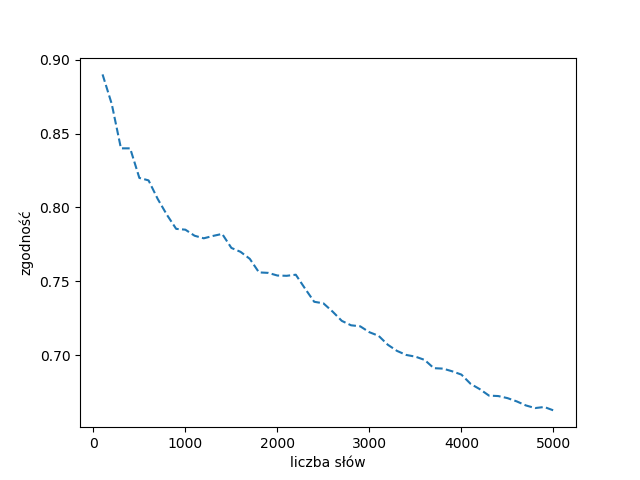

In [137]:
%matplotlib notebook
plt.plot(count_range, res, '--')
plt.xlabel('liczba słów')
plt.ylabel('zgodność')
plt.show()